<a href="https://colab.research.google.com/github/ArmandOvanessians/Disorder/blob/main/T14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import h5py
import torch
import pandas as pd
import numpy as np

In [65]:
import h5py
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, h5_file_path, df, class_col='Class', standardize=True):
        """
        Initializes the dataset by creating a list of embeddings and class labels from the HDF5 file and DataFrame.

        Parameters:
        - h5_file_path: Path to the HDF5 file containing protein embeddings.
        - df: DataFrame containing protein IDs and class labels.
        - class_col: Column name for the label. Defaults to 'Class'.
        - standardize: Whether to standardize embeddings to zero mean and unit variance. Defaults to True.
        """
        self.data = []
        embeddings = []

        # Load the HDF5 file
        with h5py.File(h5_file_path, "r") as h5_file:
            # Filter protein IDs to include only those present in the DataFrame's "ID" column
            valid_protein_ids = set(df['ID']).intersection(h5_file.keys())

            # Collect embeddings to calculate mean and std if standardization is needed
            for protein_id in valid_protein_ids:
                embedding = h5_file[protein_id][()]
                embeddings.append(embedding)

        # Standardize if needed
        if standardize:
            embeddings = torch.tensor(embeddings, dtype=torch.float)
            self.mean = embeddings.mean(dim=0)
            self.std = embeddings.std(dim=0)
            self.std[self.std == 0] = 1  # Prevent division by zero

        # Load data with standardization if applicable
        with h5py.File(h5_file_path, "r") as h5_file:
            for protein_id in valid_protein_ids:
                embedding = torch.tensor(h5_file[protein_id][()], dtype=torch.float)
                if standardize:
                    embedding = (embedding - self.mean) / self.std  # Standardize

                # Get the class label from the DataFrame
                label = torch.tensor(df.loc[df['ID'] == protein_id, class_col].values[0], dtype=torch.float)

                # Append the embedding, label, and protein ID as a dictionary
                self.data.append({'embedding': embedding, 'label': label, 'ID': protein_id})

    def __len__(self):
        # Return the number of embeddings
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve a single embedding and its label
        data = self.data[idx]
        return data['embedding'], data['label'], data['ID']
from torch.utils.data import Dataset

class CombinedSequenceDataset(Dataset):
    def __init__(self, *datasets):
        """
        Combines multiple datasets into one.

        Parameters:
        - datasets: List of SequenceDataset instances to be combined.
        """
        self.data = []

        # Append data from each dataset
        for dataset in datasets:
            self.data.extend(dataset.data)

    def __len__(self):
        # Return the total number of items across all datasets
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve a single embedding, label, and ID
        data = self.data[idx]
        return data['embedding'], data['label'], data['ID']



In [21]:

# class CombinedSequenceDataset(Dataset):
#     def __init__(self, *datasets):
#         self.data = []
#         for dataset in datasets:
#             self.data.extend(dataset.data)
#         self.standardize()

#     def standardize(self):
#         all_embeddings = torch.stack([item['embedding'] for item in self.data])
#         mean = all_embeddings.mean(dim=0)
#         std = all_embeddings.std(dim=0)

#         for item in self.data:
#             item['embedding'] = (item['embedding'] - mean) / std

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         data = self.data[idx]
#         return data['embedding'], data['label'], data['ID']

In [89]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 128, 128], dropout=0.3):
        super(MLPBinaryClassifier, self).__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.LayerNorm(dim))  # Use LayerNorm for stability
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
class ResidualMLPBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_blocks=4, dropout=0.3):
        super(ResidualMLPBinaryClassifier, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Residual blocks with consistent dimensions
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ) for _ in range(num_blocks)
        ])

        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.residual_blocks:
            x = block(x) + x  # Residual connection within each block
        return self.output_layer(x)

class EnhancedCNNMLPBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], conv_out_channels=32, kernel_size=3, dropout=0.5):
        super(EnhancedCNNMLPBinaryClassifier, self).__init__()

        # Define Conv1D layers with Batch Normalization and Dropout
        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=conv_out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(conv_out_channels),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels * 2, kernel_size=kernel_size),
            nn.BatchNorm1d(conv_out_channels * 2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout)
        )

        # Calculate the flattened dimension after Conv1D and pooling
        conv1_output_dim = input_dim - (kernel_size - 1)
        pooled1_output_dim = conv1_output_dim // 2
        conv2_output_dim = pooled1_output_dim - (kernel_size - 1)
        pooled2_output_dim = conv2_output_dim // 2
        self.flattened_dim = pooled2_output_dim * conv_out_channels * 2

        # Define MLP layers with Batch Normalization and Dropout
        self.mlp_layers = nn.Sequential(
            nn.Linear(self.flattened_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[1], 1)  # Output raw score
        )


        # Sigmoid layer to constrain output between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for Conv1D
        x = self.conv1d(x)
        x = x.view(x.size(0), -1)  # Flatten for MLP
        x = self.mlp_layers(x)
        return self.sigmoid(x)  # Apply Sigmoid to output for BCELoss

import torch
import torch.nn as nn

import torch.nn as nn

class EnhancedCNNMLPBinaryClassifier_Residual(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], conv_out_channels=32, kernel_size=3, dropout=0.5):
        super(EnhancedCNNMLPBinaryClassifier_Residual, self).__init__()

        # First Conv1D layer block with residual connection
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=conv_out_channels, kernel_size=kernel_size)
        self.bn1 = nn.BatchNorm1d(conv_out_channels)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(dropout)

        # Second Conv1D layer block with residual connection
        self.conv2 = nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels * 2, kernel_size=kernel_size)
        self.bn2 = nn.BatchNorm1d(conv_out_channels * 2)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(dropout)

        # 1x1 Convolution for channel matching in residual connections
        self.residual_conv1 = nn.Conv1d(in_channels=1, out_channels=conv_out_channels, kernel_size=1)
        self.residual_conv2 = nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels * 2, kernel_size=1)

        # Calculate the flattened dimension after Conv1D and pooling
        conv1_output_dim = input_dim - (kernel_size - 1)
        pooled1_output_dim = conv1_output_dim // 2
        conv2_output_dim = pooled1_output_dim - (kernel_size - 1)
        pooled2_output_dim = conv2_output_dim // 2
        self.flattened_dim = pooled2_output_dim * conv_out_channels * 2

        # Define MLP layers with Batch Normalization and Dropout
        self.mlp_layers = nn.Sequential(
            nn.Linear(self.flattened_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[1], 1)  # Output raw score
        )

        # Sigmoid layer to constrain output between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for Conv1D

        # First residual block
        residual1 = self.residual_conv1(x)  # Channel matching
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        # Ensure the residual and x have the same spatial dimensions
        x += residual1[:, :, :x.size(2)]  # Add the residual

        # Second residual block
        residual2 = self.residual_conv2(x)  # Channel matching
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        # Ensure the residual and x have the same spatial dimensions
        x += residual2[:, :, :x.size(2)]  # Add the residual

        # Flatten for MLP
        x = x.view(x.size(0), -1)
        x = self.mlp_layers(x)

        return self.sigmoid(x)  # Apply Sigmoid to output for BCELoss



class AdvancedCNNBinaryClassifier(nn.Module):
    def __init__(self, input_dim, conv_out_channels=64, hidden_dims=[128, 64], dropout=0.3):
        super(AdvancedCNNBinaryClassifier, self).__init__()

        # Initial Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=conv_out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(conv_out_channels)

        # Second Convolutional Block with residual connection
        self.conv3 = nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels * 2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=conv_out_channels * 2, out_channels=conv_out_channels * 2, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm1d(conv_out_channels * 2)

        # 1x1 Convolution to match dimensions for residual connection
        self.residual_connection = nn.Conv1d(conv_out_channels, conv_out_channels * 2, kernel_size=1)

        # Global Average Pooling layer to reduce dimensions
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers
        flattened_dim = conv_out_channels * 2
        self.fc1 = nn.Linear(flattened_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.output = nn.Linear(hidden_dims[1], 1)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Initial Conv Block
        residual = x.unsqueeze(1)  # (batch_size, 1, input_dim)
        x = F.relu(self.conv1(residual))
        x = self.conv2(x)
        x = self.batch_norm1(x)
        x = F.relu(x + residual)  # Residual connection

        # Second Conv Block
        residual = self.residual_connection(x)  # Adjust residual to match output channels
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = self.batch_norm2(x)
        x = F.relu(x + residual)  # Residual connection

        # Global Average Pooling
        x = self.global_pool(x).squeeze(-1)  # (batch_size, conv_out_channels * 2)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Output Layer
        return torch.sigmoid(self.output(x))
import torch
import torch.nn as nn

class TransformerBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, nhead=4, num_layers=2, dropout=0.5, max_seq_len=1000):
        """
        Transformer-based binary classifier.

        Args:
            input_dim (int): Number of input features per sequence element.
            hidden_dim (int): Dimension of the Transformer and MLP hidden layers.
            nhead (int): Number of attention heads in the Transformer.
            num_layers (int): Number of Transformer encoder layers.
            dropout (float): Dropout rate.
            max_seq_len (int): Maximum expected sequence length for positional encoding.
        """
        super(TransformerBinaryClassifier, self).__init__()

        # Input mapping layer (optional)
        self.input_mapping = nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else None

        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, max_seq_len, hidden_dim), requires_grad=True)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dropout=dropout,
            batch_first=True  # Ensures input shape is (batch_size, seq_len, hidden_dim)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Pooling layer to aggregate sequence information
        self.pool = nn.AdaptiveAvgPool1d(1)  # Outputs shape: (batch_size, hidden_dim, 1)

        # MLP for classification
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

        # Sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Forward pass of the TransformerBinaryClassifier.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_dim) or (batch_size, input_dim).

        Returns:
            torch.Tensor: Output probabilities of shape (batch_size, 1).
        """
        # Ensure input has three dimensions
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Shape becomes (batch_size, seq_len=1, input_dim)

        # Input mapping if necessary
        if self.input_mapping is not None:
            x = self.input_mapping(x)  # Shape: (batch_size, seq_len, hidden_dim)

        # Add positional encoding
        batch_size, seq_len, _ = x.size()
        if seq_len > self.positional_encoding.size(1):
            raise ValueError(f"Sequence length {seq_len} exceeds maximum positional encoding length {self.positional_encoding.size(1)}.")
        positional_encoding = self.positional_encoding[:, :seq_len, :]  # Shape: (1, seq_len, hidden_dim)
        x = x + positional_encoding  # Broadcasting over batch_size

        # Transformer Encoder
        x = self.transformer_encoder(x)  # Shape: (batch_size, seq_len, hidden_dim)

        # Pooling over the sequence length dimension
        x = x.permute(0, 2, 1)  # Shape: (batch_size, hidden_dim, seq_len)
        x = self.pool(x)         # Shape: (batch_size, hidden_dim, 1)
        x = x.squeeze(2)         # Shape: (batch_size, hidden_dim)

        # MLP and Sigmoid
        x = self.mlp(x)          # Shape: (batch_size, 1)
        return self.sigmoid(x)


In [30]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
def save_fold_data(fold, train_indices, train_ids, val_indices, val_ids):
    """Save training and validation data (both indices and IDs) for each fold."""
    fold_data = {
        'train_indices': train_indices,
        'train_ids': train_ids,
        'val_indices': val_indices,
        'val_ids': val_ids
    }
    with open(f"fold_{fold + 1}_data.pkl", "wb") as file:
        pickle.dump(fold_data, file)
    print(f"Training and validation data (indices and IDs) for Fold {fold + 1} saved.")

def benchmark_models(dataset, df, device, model_classes, num_epochs=10, batch_size=32,
                    learning_rate=1e-4, hidden_dim=64, pos_weight=1.0, neg_weight=1.0,
                    k_folds=5, augment_minority_class=False, weight_decay=0.0,
                    patience=10, save_directory='saved_models'):

    # Ensure the save directory exists
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        print(f"Created directory for saving models: {save_directory}")

    first_sequence, _, _ = dataset[0]
    input_dim = first_sequence.shape[-1]

    gene_to_indices = {}
    for idx, (_, _, gene_id) in enumerate(dataset):
        gene_name = gene_id.split("-")[0]
        if gene_name not in gene_to_indices:
            gene_to_indices[gene_name] = []
        gene_to_indices[gene_name].append(idx)

    gene_classes = []
    for gene_name, indices in gene_to_indices.items():
        gene_ids = [dataset[i][2] for i in indices]
        class_labels = df[df['ID'].isin(gene_ids)]['Class']
        majority_class = class_labels.mode()[0]
        gene_classes.append((gene_name, majority_class))

    gene_names, gene_labels = zip(*gene_classes)

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    all_results = {}

    for model_class in model_classes:
        print(f"\n=== Benchmarking Model: {model_class.__name__} ===\n")
        results = []
        best_val_accuracy = 0.0
        best_model_state = None

        for fold, (train_gene_idxs, val_gene_idxs) in enumerate(skf.split(gene_names, gene_labels)):
            print(f"\nFOLD {fold + 1}/{k_folds}")

            train_genes = [gene_names[i] for i in train_gene_idxs]
            val_genes = [gene_names[i] for i in val_gene_idxs]

            train_indices = [idx for gene in train_genes for idx in gene_to_indices[gene]]
            val_indices = [idx for gene in val_genes for idx in gene_to_indices[gene]]

            train_ids = [dataset[idx][2] for idx in train_indices]
            val_ids = [dataset[idx][2] for idx in val_indices]

            save_fold_data(fold, train_indices, train_ids, val_indices, val_ids)

            train_subset = Subset(dataset, train_indices)
            val_subset = Subset(dataset, val_indices)

            # Initialize each model with appropriate parameters
            if model_class.__name__ == "MLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dims=[128, 64, 32], dropout=0.4).to(device)
            elif model_class.__name__ == "AdvancedCNNBinaryClassifier":
                model = model_class(
                    input_dim=input_dim,
                    conv_out_channels=64,
                    hidden_dims=[128, 64],
                    dropout=0.3
                ).to(device)
            elif model_class.__name__ == "ResidualMLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dim=128, dropout=0.4).to(device)
            elif model_class.__name__ == "EnhancedCNNMLPBinaryClassifier":
                model = model_class(
                    input_dim=input_dim,
                    hidden_dims=[128, 64],
                    conv_out_channels=32,
                    kernel_size=3,
                    dropout=0.5
                ).to(device)
            elif model_class.__name__ == "EnhancedCNNMLPBinaryClassifier_Residual":
                model = model_class(
                    input_dim=input_dim,
                    hidden_dims=[128, 64],
                    conv_out_channels=32,
                    kernel_size=3,
                    dropout=0.5
                ).to(device)
            elif model_class.__name__ == "TransformerBinaryClassifier":
                model = model_class(
                    input_dim=input_dim,
                    hidden_dim=hidden_dim,
                    nhead=4,
                    num_layers=2,
                    dropout=0.1
                ).to(device)
            else:
                raise ValueError(f"Unknown model class: {model_class.__name__}")

            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

            criterion = nn.BCELoss(reduction='none')
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            best_val_loss = float('inf')
            epochs_without_improvement = 0

            train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

            for epoch in range(num_epochs):
                model.train()
                train_loss, correct_train, total_train = 0, 0, 0

                for batch in train_loader:
                    sequences, labels, _ = batch
                    sequences, labels = sequences.to(device), labels.to(device)

                    weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                    logits = model(sequences).squeeze(dim=1)
                    loss_per_sample = criterion(logits, labels.float())
                    loss = (loss_per_sample * weight).mean()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item() * sequences.size(0)
                    preds = (logits > 0.5).float()
                    correct_train += (preds == labels).sum().item()
                    total_train += labels.size(0)

                train_losses.append(train_loss / total_train)
                train_accuracies.append(correct_train / total_train)

                model.eval()
                val_loss, correct_val, total_val = 0, 0, 0
                val_labels, val_preds, val_logits = [], [], []

                with torch.no_grad():
                    for batch in val_loader:
                        sequences, labels, _ = batch
                        sequences, labels = sequences.to(device), labels.to(device)

                        logits = model(sequences).squeeze()
                        loss_per_sample = criterion(logits.view(-1), labels.float().view(-1))
                        weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                        val_loss += (loss_per_sample * weight).mean().item() * sequences.size(0)

                        predictions = (logits > 0.5).float()

                        if predictions.dim() == 0:
                            predictions = predictions.unsqueeze(0)  # Ensure predictions is 1-dimensional

                        correct_val += (predictions == labels).sum().item()
                        total_val += labels.size(0)

                        # Convert tensors to lists or handle scalars before extending
                        val_labels.extend(labels.cpu().numpy())
                        val_preds.extend(predictions.cpu().numpy().tolist())

                        # Handle logits being a scalar
                        val_logits.extend(logits.cpu().numpy().tolist() if logits.dim() > 0 else [logits.cpu().item()])

                val_losses.append(val_loss / total_val)
                val_accuracies.append(correct_val / total_val)

                print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1

                if epochs_without_improvement >= patience:
                    print(f"Early stopping triggered after {epoch+1} epochs.")
                    break

            # After training, save the best model weights for this fold
            model_filename = f"{model_class.__name__}_fold{fold + 1}_weights.pth"
            model_path = os.path.join(save_directory, model_filename)
            torch.save(best_model_state, model_path)
            print(f"Saved model weights for {model_class.__name__} Fold {fold + 1} at {model_path}")

            precision = precision_score(val_labels, val_preds, zero_division=0)
            recall = recall_score(val_labels, val_preds)
            f1 = f1_score(val_labels, val_preds)
            auc_roc = roc_auc_score(val_labels, val_logits)

            print(f"Fold {fold + 1} Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")

            cm = confusion_matrix(val_labels, val_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
            disp.plot(cmap="Blues")
            plt.title(f'Confusion Matrix - Fold {fold + 1} - Model: {model_class.__name__}')
            plt.show()

            results.append({
                'Fold': fold + 1,
                'Validation Accuracy': val_accuracies[-1],
                'Validation Loss': val_losses[-1],
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'AUC-ROC': auc_roc
            })

        avg_accuracy = sum(result['Validation Accuracy'] for result in results) / k_folds
        avg_precision = sum(result['Precision'] for result in results) / k_folds
        avg_recall = sum(result['Recall'] for result in results) / k_folds
        avg_f1 = sum(result['F1 Score'] for result in results) / k_folds
        avg_auc_roc = sum(result['AUC-ROC'] for result in results) / k_folds

        print(f"\nModel: {model_class.__name__} - Average Validation Accuracy: {avg_accuracy:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print(f"Average Recall: {avg_recall:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print(f"Average AUC-ROC: {avg_auc_roc:.4f}")

        all_results[model_class.__name__] = {
            'Avg Validation Accuracy': avg_accuracy,
            'Avg Precision': avg_precision,
            'Avg Recall': avg_recall,
            'Avg F1 Score': avg_f1,
            'Avg AUC-ROC': avg_auc_roc
        }

    return all_results


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [22]:
data_rep = 'per_protein_embeddings_repression.h5'
data_act = 'per_protein_embeddings_activation_bintu.h5'
data_Bintu = 'BINTU_FULL.csv'
df_Bintu = pd.read_csv(data_Bintu)
df_Bintu = df_Bintu.drop(df_Bintu.columns[0], axis=1)
d_act = SequenceDataset(h5_file_path=data_act, df=df_Bintu)
d_rep = SequenceDataset(h5_file_path=data_rep, df=df_Bintu)
# Combine d_act and d_rep
combined_dataset = CombinedSequenceDataset(d_rep, d_act)

In [26]:
se,_, _ = combined_dataset[0]
print(se.shape)

torch.Size([1024])


Load in Bintu


=== Benchmarking Model: EnhancedCNNMLPBinaryClassifier_Residual ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Epoch [1/100], Train Loss: 0.6192, Val Loss: 0.6014, Train Acc: 0.6550, Val Acc: 0.7651
Epoch [2/100], Train Loss: 0.5099, Val Loss: 0.5062, Train Acc: 0.8139, Val Acc: 0.8514
Epoch [3/100], Train Loss: 0.4450, Val Loss: 0.4495, Train Acc: 0.8619, Val Acc: 0.8675
Epoch [4/100], Train Loss: 0.3884, Val Loss: 0.4080, Train Acc: 0.8876, Val Acc: 0.8775
Epoch [5/100], Train Loss: 0.3548, Val Loss: 0.3753, Train Acc: 0.8941, Val Acc: 0.8855
Epoch [6/100], Train Loss: 0.3304, Val Loss: 0.3392, Train Acc: 0.9059, Val Acc: 0.9016
Epoch [7/100], Train Loss: 0.3047, Val Loss: 0.3499, Train Acc: 0.9094, Val Acc: 0.8956
Epoch [8/100], Train Loss: 0.2922, Val Loss: 0.3106, Train Acc: 0.9124, Val Acc: 0.9056
Epoch [9/100], Train Loss: 0.2732, Val Loss: 0.2989, Train Acc: 0.9139, Val Acc: 0.9056
Epoch [10/100], Train Loss: 0.2686, Val Loss: 0.2924, Train Acc

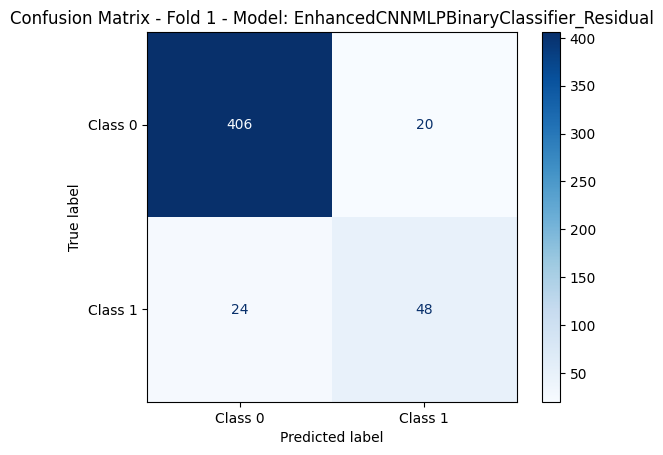


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Epoch [1/100], Train Loss: 0.7209, Val Loss: 0.6404, Train Acc: 0.5339, Val Acc: 0.6841
Epoch [2/100], Train Loss: 0.5904, Val Loss: 0.5025, Train Acc: 0.7081, Val Acc: 0.8773
Epoch [3/100], Train Loss: 0.5066, Val Loss: 0.4357, Train Acc: 0.8055, Val Acc: 0.9054
Epoch [4/100], Train Loss: 0.4504, Val Loss: 0.4076, Train Acc: 0.8491, Val Acc: 0.9115
Epoch [5/100], Train Loss: 0.3979, Val Loss: 0.3576, Train Acc: 0.8822, Val Acc: 0.9135
Epoch [6/100], Train Loss: 0.3667, Val Loss: 0.3407, Train Acc: 0.8837, Val Acc: 0.9115
Epoch [7/100], Train Loss: 0.3393, Val Loss: 0.3101, Train Acc: 0.8946, Val Acc: 0.9155
Epoch [8/100], Train Loss: 0.3308, Val Loss: 0.2964, Train Acc: 0.9045, Val Acc: 0.9175
Epoch [9/100], Train Loss: 0.3079, Val Loss: 0.2771, Train Acc: 0.8976, Val Acc: 0.9155
Epoch [10/100], Train Loss: 0.2877, Val Loss: 0.2741, Train Acc: 0.9090, Val Acc: 0.9195
Epoch [11/100], Train Loss: 0.2784, Val Loss

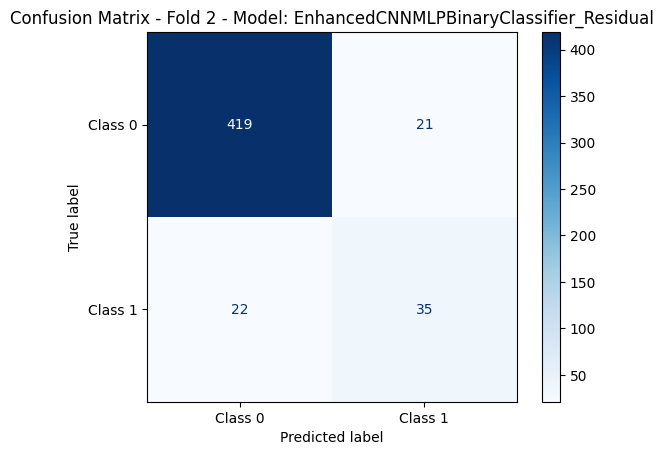


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Epoch [1/100], Train Loss: 0.6918, Val Loss: 0.5622, Train Acc: 0.5677, Val Acc: 0.8245
Epoch [2/100], Train Loss: 0.5598, Val Loss: 0.5350, Train Acc: 0.7646, Val Acc: 0.8391
Epoch [3/100], Train Loss: 0.4877, Val Loss: 0.4645, Train Acc: 0.8382, Val Acc: 0.8757
Epoch [4/100], Train Loss: 0.4310, Val Loss: 0.4089, Train Acc: 0.8858, Val Acc: 0.8812
Epoch [5/100], Train Loss: 0.3885, Val Loss: 0.3671, Train Acc: 0.8929, Val Acc: 0.8903
Epoch [6/100], Train Loss: 0.3555, Val Loss: 0.3541, Train Acc: 0.8950, Val Acc: 0.8885
Epoch [7/100], Train Loss: 0.3301, Val Loss: 0.3327, Train Acc: 0.9158, Val Acc: 0.8885
Epoch [8/100], Train Loss: 0.3021, Val Loss: 0.3355, Train Acc: 0.9163, Val Acc: 0.8848
Epoch [9/100], Train Loss: 0.3041, Val Loss: 0.2962, Train Acc: 0.9102, Val Acc: 0.8958
Epoch [10/100], Train Loss: 0.2856, Val Loss: 0.2883, Train Acc: 0.9102, Val Acc: 0.8848
Epoch [11/100], Train Loss: 0.2708, Val Loss

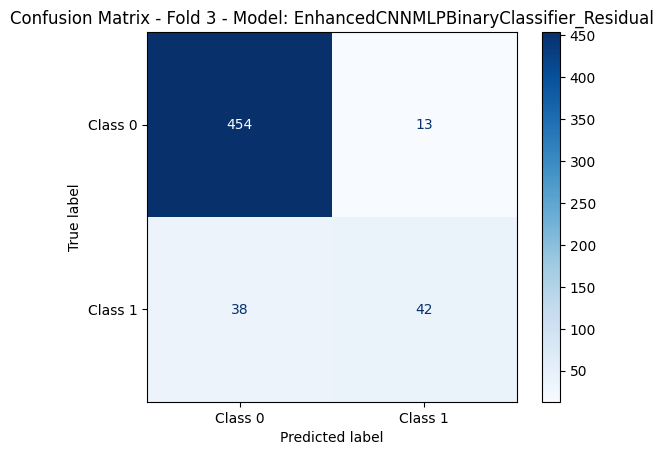


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Epoch [1/100], Train Loss: 0.5618, Val Loss: 0.4862, Train Acc: 0.7366, Val Acc: 0.8933
Epoch [2/100], Train Loss: 0.4586, Val Loss: 0.4217, Train Acc: 0.8534, Val Acc: 0.9111
Epoch [3/100], Train Loss: 0.4063, Val Loss: 0.3811, Train Acc: 0.8743, Val Acc: 0.9150
Epoch [4/100], Train Loss: 0.3670, Val Loss: 0.3464, Train Acc: 0.8926, Val Acc: 0.9249
Epoch [5/100], Train Loss: 0.3374, Val Loss: 0.3363, Train Acc: 0.8926, Val Acc: 0.9190
Epoch [6/100], Train Loss: 0.3240, Val Loss: 0.3131, Train Acc: 0.8981, Val Acc: 0.9170
Epoch [7/100], Train Loss: 0.3070, Val Loss: 0.2729, Train Acc: 0.8951, Val Acc: 0.9308
Epoch [8/100], Train Loss: 0.2912, Val Loss: 0.2730, Train Acc: 0.9085, Val Acc: 0.9269
Epoch [9/100], Train Loss: 0.2736, Val Loss: 0.2726, Train Acc: 0.9155, Val Acc: 0.9289
Epoch [10/100], Train Loss: 0.2640, Val Loss: 0.2743, Train Acc: 0.9145, Val Acc: 0.9249
Epoch [11/100], Train Loss: 0.2604, Val Loss

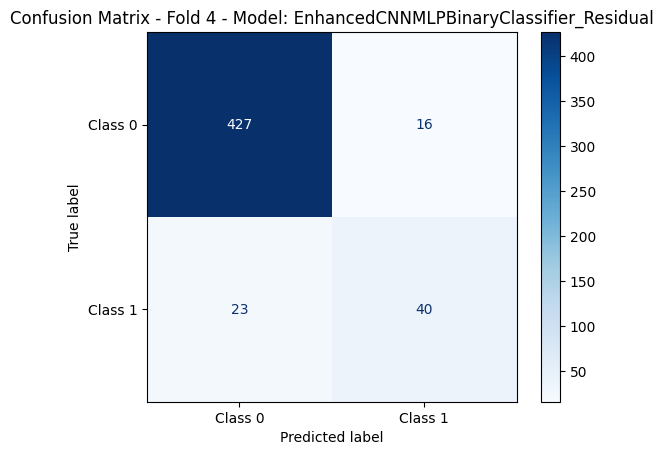


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Epoch [1/100], Train Loss: 0.6607, Val Loss: 0.5972, Train Acc: 0.6113, Val Acc: 0.7851
Epoch [2/100], Train Loss: 0.5497, Val Loss: 0.5051, Train Acc: 0.7656, Val Acc: 0.8596
Epoch [3/100], Train Loss: 0.4658, Val Loss: 0.4371, Train Acc: 0.8501, Val Acc: 0.9085
Epoch [4/100], Train Loss: 0.4225, Val Loss: 0.3983, Train Acc: 0.8721, Val Acc: 0.9191
Epoch [5/100], Train Loss: 0.3794, Val Loss: 0.3563, Train Acc: 0.8867, Val Acc: 0.9298
Epoch [6/100], Train Loss: 0.3441, Val Loss: 0.3239, Train Acc: 0.9038, Val Acc: 0.9340
Epoch [7/100], Train Loss: 0.3287, Val Loss: 0.3219, Train Acc: 0.8970, Val Acc: 0.9298
Epoch [8/100], Train Loss: 0.3037, Val Loss: 0.2892, Train Acc: 0.9019, Val Acc: 0.9340
Epoch [9/100], Train Loss: 0.2944, Val Loss: 0.2523, Train Acc: 0.9102, Val Acc: 0.9404
Epoch [10/100], Train Loss: 0.2688, Val Loss: 0.2813, Train Acc: 0.9150, Val Acc: 0.9340
Epoch [11/100], Train Loss: 0.2717, Val Loss

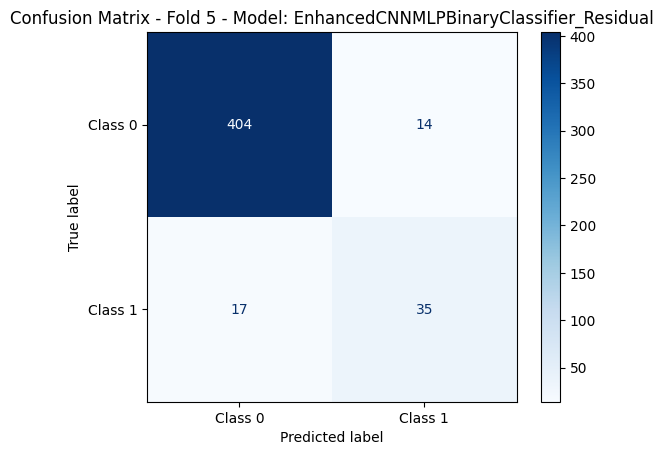


Model: EnhancedCNNMLPBinaryClassifier_Residual - Average Validation Accuracy: 0.9178
Average Precision: 0.7046
Average Recall: 0.6227
Average F1 Score: 0.6585
Average AUC-ROC: 0.9151

=== Benchmarking Model: MLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Epoch [1/100], Train Loss: 0.5504, Val Loss: 0.3905, Train Acc: 0.7525, Val Acc: 0.8574
Epoch [2/100], Train Loss: 0.4093, Val Loss: 0.3366, Train Acc: 0.8743, Val Acc: 0.8755
Epoch [3/100], Train Loss: 0.3586, Val Loss: 0.3087, Train Acc: 0.8896, Val Acc: 0.8855
Epoch [4/100], Train Loss: 0.3205, Val Loss: 0.2902, Train Acc: 0.8980, Val Acc: 0.9016
Epoch [5/100], Train Loss: 0.2910, Val Loss: 0.2777, Train Acc: 0.9079, Val Acc: 0.8956
Epoch [6/100], Train Loss: 0.2769, Val Loss: 0.2746, Train Acc: 0.9149, Val Acc: 0.8916
Epoch [7/100], Train Loss: 0.2628, Val Loss: 0.2714, Train Acc: 0.9178, Val Acc: 0.8936
Epoch [8/100], Train Loss: 0.2426, Val Loss: 0.2685, Train Acc: 0.9233, Val

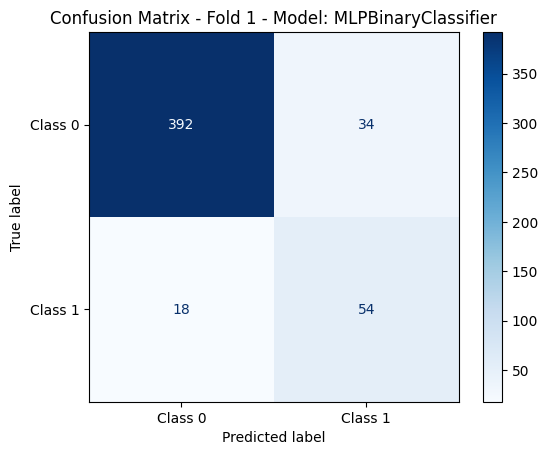


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Epoch [1/100], Train Loss: 0.5006, Val Loss: 0.3467, Train Acc: 0.8367, Val Acc: 0.8853
Epoch [2/100], Train Loss: 0.3957, Val Loss: 0.2950, Train Acc: 0.8674, Val Acc: 0.9054
Epoch [3/100], Train Loss: 0.3440, Val Loss: 0.2650, Train Acc: 0.8857, Val Acc: 0.9195
Epoch [4/100], Train Loss: 0.3169, Val Loss: 0.2468, Train Acc: 0.8867, Val Acc: 0.9195
Epoch [5/100], Train Loss: 0.2954, Val Loss: 0.2393, Train Acc: 0.8966, Val Acc: 0.9155
Epoch [6/100], Train Loss: 0.2569, Val Loss: 0.2393, Train Acc: 0.9114, Val Acc: 0.9115
Epoch [7/100], Train Loss: 0.2524, Val Loss: 0.2370, Train Acc: 0.9169, Val Acc: 0.9175
Epoch [8/100], Train Loss: 0.2305, Val Loss: 0.2348, Train Acc: 0.9169, Val Acc: 0.9115
Epoch [9/100], Train Loss: 0.2309, Val Loss: 0.2427, Train Acc: 0.9193, Val Acc: 0.9095
Epoch [10/100], Train Loss: 0.2111, Val Loss: 0.2382, Train Acc: 0.9302, Val Acc: 0.9095
Epoch [11/100], Train Loss: 0.2161, Val Loss

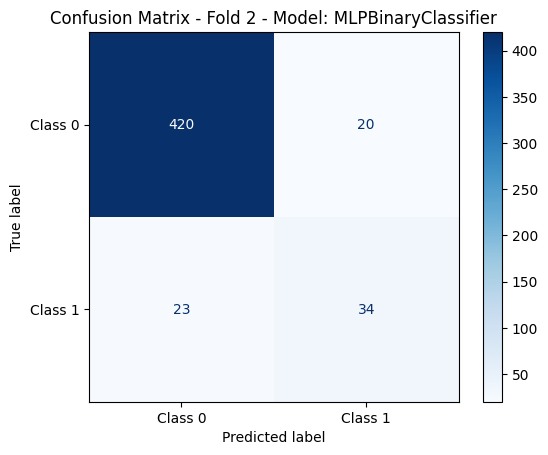


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Epoch [1/100], Train Loss: 0.5798, Val Loss: 0.4052, Train Acc: 0.7220, Val Acc: 0.8647
Epoch [2/100], Train Loss: 0.4179, Val Loss: 0.3503, Train Acc: 0.8874, Val Acc: 0.8885
Epoch [3/100], Train Loss: 0.3659, Val Loss: 0.3204, Train Acc: 0.8955, Val Acc: 0.8921
Epoch [4/100], Train Loss: 0.3294, Val Loss: 0.3022, Train Acc: 0.9011, Val Acc: 0.8958
Epoch [5/100], Train Loss: 0.2967, Val Loss: 0.2947, Train Acc: 0.9127, Val Acc: 0.8885
Epoch [6/100], Train Loss: 0.2767, Val Loss: 0.2847, Train Acc: 0.9224, Val Acc: 0.8995
Epoch [7/100], Train Loss: 0.2624, Val Loss: 0.2716, Train Acc: 0.9209, Val Acc: 0.9049
Epoch [8/100], Train Loss: 0.2554, Val Loss: 0.2672, Train Acc: 0.9239, Val Acc: 0.9068
Epoch [9/100], Train Loss: 0.2422, Val Loss: 0.2695, Train Acc: 0.9300, Val Acc: 0.9068
Epoch [10/100], Train Loss: 0.2281, Val Loss: 0.2670, Train Acc: 0.9346, Val Acc: 0.8995
Epoch [11/100], Train Loss: 0.2160, Val Loss

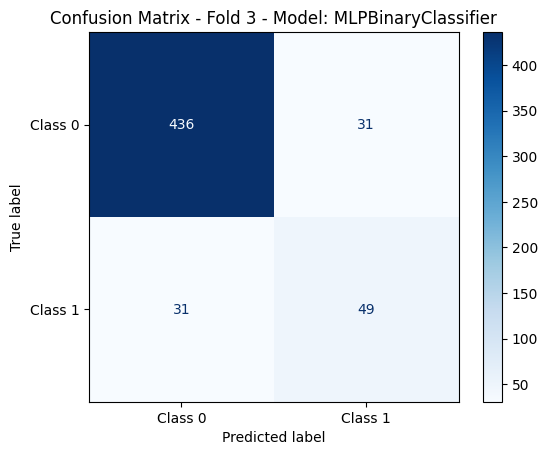


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Epoch [1/100], Train Loss: 0.6020, Val Loss: 0.3757, Train Acc: 0.6784, Val Acc: 0.8893
Epoch [2/100], Train Loss: 0.4170, Val Loss: 0.3095, Train Acc: 0.8648, Val Acc: 0.8874
Epoch [3/100], Train Loss: 0.3677, Val Loss: 0.2753, Train Acc: 0.8852, Val Acc: 0.9032
Epoch [4/100], Train Loss: 0.3324, Val Loss: 0.2534, Train Acc: 0.8941, Val Acc: 0.9229
Epoch [5/100], Train Loss: 0.3029, Val Loss: 0.2397, Train Acc: 0.9001, Val Acc: 0.9269
Epoch [6/100], Train Loss: 0.2816, Val Loss: 0.2330, Train Acc: 0.9110, Val Acc: 0.9209
Epoch [7/100], Train Loss: 0.2661, Val Loss: 0.2266, Train Acc: 0.9205, Val Acc: 0.9190
Epoch [8/100], Train Loss: 0.2477, Val Loss: 0.2143, Train Acc: 0.9195, Val Acc: 0.9190
Epoch [9/100], Train Loss: 0.2414, Val Loss: 0.2160, Train Acc: 0.9269, Val Acc: 0.9209
Epoch [10/100], Train Loss: 0.2230, Val Loss: 0.2163, Train Acc: 0.9304, Val Acc: 0.9229
Epoch [11/100], Train Loss: 0.2244, Val Loss

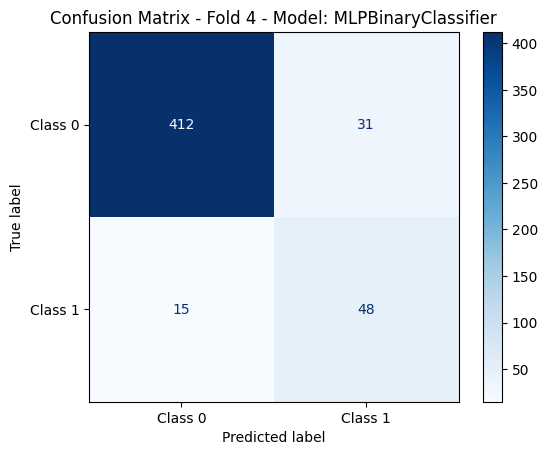


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Epoch [1/100], Train Loss: 0.6741, Val Loss: 0.4545, Train Acc: 0.5742, Val Acc: 0.8979
Epoch [2/100], Train Loss: 0.4890, Val Loss: 0.3596, Train Acc: 0.8486, Val Acc: 0.9128
Epoch [3/100], Train Loss: 0.4072, Val Loss: 0.3037, Train Acc: 0.8813, Val Acc: 0.9277
Epoch [4/100], Train Loss: 0.3650, Val Loss: 0.2694, Train Acc: 0.8921, Val Acc: 0.9298
Epoch [5/100], Train Loss: 0.3352, Val Loss: 0.2496, Train Acc: 0.9023, Val Acc: 0.9255
Epoch [6/100], Train Loss: 0.3104, Val Loss: 0.2352, Train Acc: 0.9131, Val Acc: 0.9340
Epoch [7/100], Train Loss: 0.2870, Val Loss: 0.2208, Train Acc: 0.9170, Val Acc: 0.9340
Epoch [8/100], Train Loss: 0.2673, Val Loss: 0.2139, Train Acc: 0.9263, Val Acc: 0.9362
Epoch [9/100], Train Loss: 0.2565, Val Loss: 0.2073, Train Acc: 0.9302, Val Acc: 0.9362
Epoch [10/100], Train Loss: 0.2401, Val Loss: 0.2062, Train Acc: 0.9331, Val Acc: 0.9362
Epoch [11/100], Train Loss: 0.2234, Val Loss

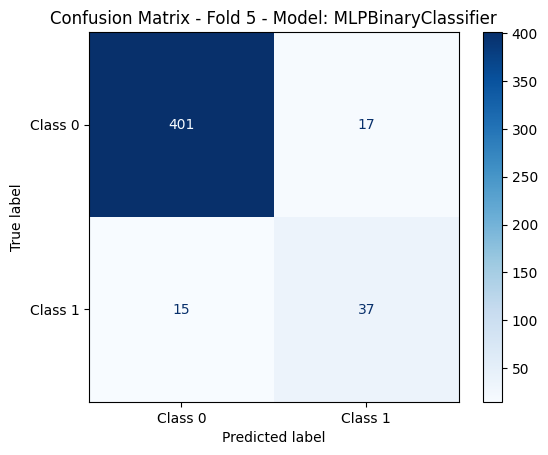


Model: MLPBinaryClassifier - Average Validation Accuracy: 0.9073
Average Precision: 0.6297
Average Recall: 0.6865
Average F1 Score: 0.6549
Average AUC-ROC: 0.9085

=== Benchmarking Model: ResidualMLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Epoch [1/100], Train Loss: 0.3097, Val Loss: 0.2705, Train Acc: 0.8807, Val Acc: 0.8795
Epoch [2/100], Train Loss: 0.2391, Val Loss: 0.2483, Train Acc: 0.8985, Val Acc: 0.9076
Epoch [3/100], Train Loss: 0.2071, Val Loss: 0.2481, Train Acc: 0.9158, Val Acc: 0.9036
Epoch [4/100], Train Loss: 0.1936, Val Loss: 0.2461, Train Acc: 0.9243, Val Acc: 0.9036
Epoch [5/100], Train Loss: 0.1752, Val Loss: 0.2519, Train Acc: 0.9277, Val Acc: 0.8936
Epoch [6/100], Train Loss: 0.1659, Val Loss: 0.2546, Train Acc: 0.9287, Val Acc: 0.8996
Epoch [7/100], Train Loss: 0.1521, Val Loss: 0.2553, Train Acc: 0.9376, Val Acc: 0.8976
Epoch [8/100], Train Loss: 0.1452, Val Loss: 0.2730, Train Acc: 0.9376, Val Acc: 0.9036

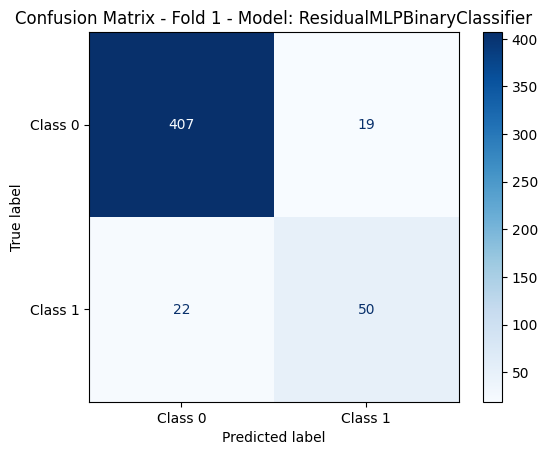


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Epoch [1/100], Train Loss: 0.3164, Val Loss: 0.2100, Train Acc: 0.8793, Val Acc: 0.9095
Epoch [2/100], Train Loss: 0.2483, Val Loss: 0.2011, Train Acc: 0.8971, Val Acc: 0.9195
Epoch [3/100], Train Loss: 0.2208, Val Loss: 0.1996, Train Acc: 0.9080, Val Acc: 0.9175
Epoch [4/100], Train Loss: 0.1972, Val Loss: 0.2014, Train Acc: 0.9159, Val Acc: 0.9215
Epoch [5/100], Train Loss: 0.1801, Val Loss: 0.2155, Train Acc: 0.9238, Val Acc: 0.9256
Epoch [6/100], Train Loss: 0.1740, Val Loss: 0.2040, Train Acc: 0.9243, Val Acc: 0.9256
Epoch [7/100], Train Loss: 0.1609, Val Loss: 0.2199, Train Acc: 0.9302, Val Acc: 0.9235
Epoch [8/100], Train Loss: 0.1514, Val Loss: 0.2232, Train Acc: 0.9357, Val Acc: 0.9235
Epoch [9/100], Train Loss: 0.1391, Val Loss: 0.2325, Train Acc: 0.9451, Val Acc: 0.9215
Epoch [10/100], Train Loss: 0.1312, Val Loss: 0.2463, Train Acc: 0.9471, Val Acc: 0.9215
Epoch [11/100], Train Loss: 0.1295, Val Loss

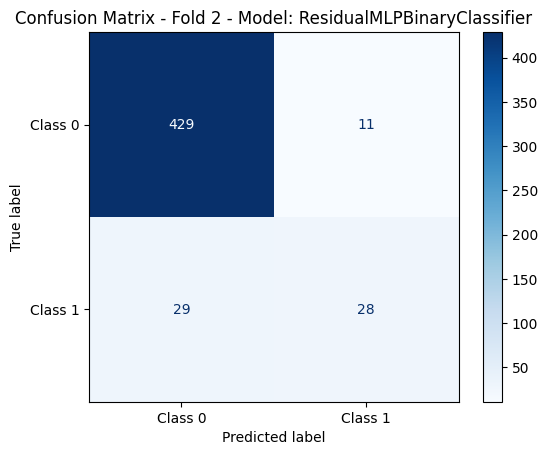


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Epoch [1/100], Train Loss: 0.3606, Val Loss: 0.2811, Train Acc: 0.8432, Val Acc: 0.8940
Epoch [2/100], Train Loss: 0.2491, Val Loss: 0.2534, Train Acc: 0.9006, Val Acc: 0.8958
Epoch [3/100], Train Loss: 0.2152, Val Loss: 0.2517, Train Acc: 0.9158, Val Acc: 0.9049
Epoch [4/100], Train Loss: 0.2118, Val Loss: 0.2476, Train Acc: 0.9132, Val Acc: 0.9013
Epoch [5/100], Train Loss: 0.1978, Val Loss: 0.2422, Train Acc: 0.9203, Val Acc: 0.9049
Epoch [6/100], Train Loss: 0.1751, Val Loss: 0.2656, Train Acc: 0.9305, Val Acc: 0.9049
Epoch [7/100], Train Loss: 0.1646, Val Loss: 0.2509, Train Acc: 0.9285, Val Acc: 0.8995
Epoch [8/100], Train Loss: 0.1522, Val Loss: 0.2511, Train Acc: 0.9305, Val Acc: 0.9013
Epoch [9/100], Train Loss: 0.1371, Val Loss: 0.2652, Train Acc: 0.9447, Val Acc: 0.9031
Epoch [10/100], Train Loss: 0.1331, Val Loss: 0.2823, Train Acc: 0.9508, Val Acc: 0.9013
Epoch [11/100], Train Loss: 0.1177, Val Loss

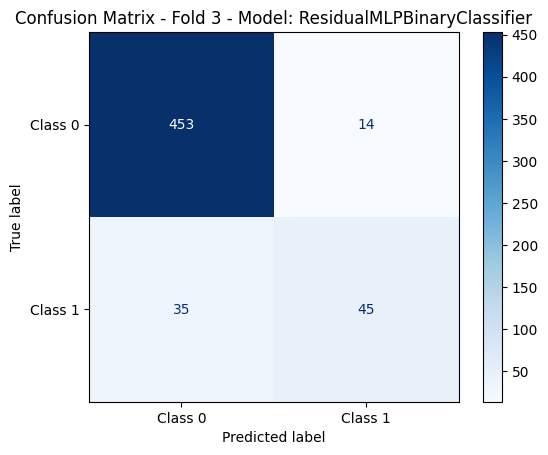


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Epoch [1/100], Train Loss: 0.3487, Val Loss: 0.2443, Train Acc: 0.8534, Val Acc: 0.8972
Epoch [2/100], Train Loss: 0.2487, Val Loss: 0.2284, Train Acc: 0.8907, Val Acc: 0.9150
Epoch [3/100], Train Loss: 0.2186, Val Loss: 0.2219, Train Acc: 0.9085, Val Acc: 0.9209
Epoch [4/100], Train Loss: 0.2107, Val Loss: 0.2256, Train Acc: 0.9155, Val Acc: 0.9130
Epoch [5/100], Train Loss: 0.1936, Val Loss: 0.2268, Train Acc: 0.9170, Val Acc: 0.9170
Epoch [6/100], Train Loss: 0.1792, Val Loss: 0.2257, Train Acc: 0.9240, Val Acc: 0.9229
Epoch [7/100], Train Loss: 0.1633, Val Loss: 0.2361, Train Acc: 0.9329, Val Acc: 0.9130
Epoch [8/100], Train Loss: 0.1508, Val Loss: 0.2294, Train Acc: 0.9399, Val Acc: 0.9249
Epoch [9/100], Train Loss: 0.1381, Val Loss: 0.2356, Train Acc: 0.9433, Val Acc: 0.9269
Epoch [10/100], Train Loss: 0.1335, Val Loss: 0.2365, Train Acc: 0.9443, Val Acc: 0.9269
Epoch [11/100], Train Loss: 0.1350, Val Loss

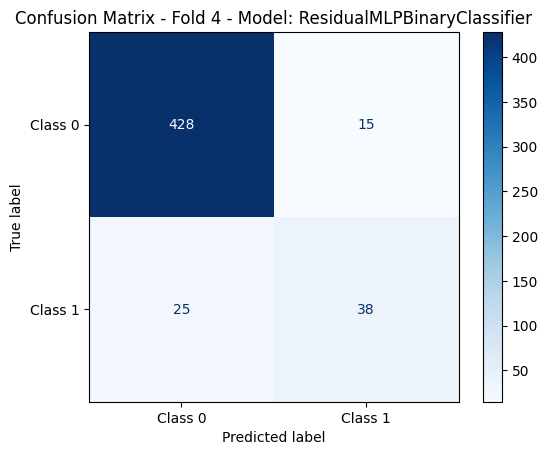


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Epoch [1/100], Train Loss: 0.3465, Val Loss: 0.2047, Train Acc: 0.8633, Val Acc: 0.9191
Epoch [2/100], Train Loss: 0.2452, Val Loss: 0.1883, Train Acc: 0.8945, Val Acc: 0.9213
Epoch [3/100], Train Loss: 0.2222, Val Loss: 0.1879, Train Acc: 0.9067, Val Acc: 0.9340
Epoch [4/100], Train Loss: 0.1968, Val Loss: 0.1836, Train Acc: 0.9238, Val Acc: 0.9277
Epoch [5/100], Train Loss: 0.1978, Val Loss: 0.1849, Train Acc: 0.9194, Val Acc: 0.9340
Epoch [6/100], Train Loss: 0.1697, Val Loss: 0.1828, Train Acc: 0.9277, Val Acc: 0.9404
Epoch [7/100], Train Loss: 0.1596, Val Loss: 0.1928, Train Acc: 0.9336, Val Acc: 0.9319
Epoch [8/100], Train Loss: 0.1496, Val Loss: 0.1956, Train Acc: 0.9424, Val Acc: 0.9319
Epoch [9/100], Train Loss: 0.1429, Val Loss: 0.1914, Train Acc: 0.9448, Val Acc: 0.9404
Epoch [10/100], Train Loss: 0.1339, Val Loss: 0.1962, Train Acc: 0.9473, Val Acc: 0.9404
Epoch [11/100], Train Loss: 0.1276, Val Loss

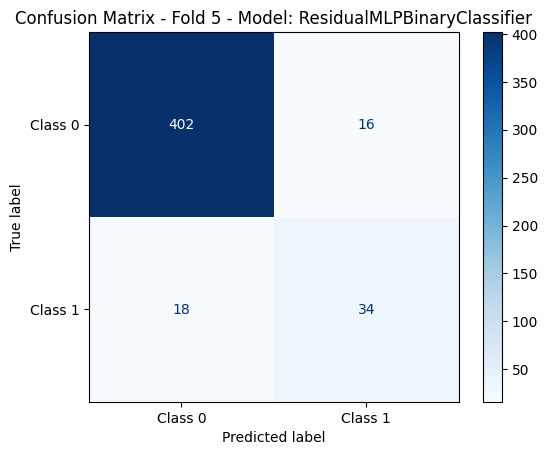


Model: ResidualMLPBinaryClassifier - Average Validation Accuracy: 0.9192
Average Precision: 0.7205
Average Recall: 0.6010
Average F1 Score: 0.6524
Average AUC-ROC: 0.9227

=== Benchmarking Model: EnhancedCNNMLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Epoch [1/100], Train Loss: 0.6373, Val Loss: 0.5739, Train Acc: 0.6386, Val Acc: 0.8474
Epoch [2/100], Train Loss: 0.5343, Val Loss: 0.5939, Train Acc: 0.7960, Val Acc: 0.8554
Epoch [3/100], Train Loss: 0.4678, Val Loss: 0.5217, Train Acc: 0.8475, Val Acc: 0.8775
Epoch [4/100], Train Loss: 0.4171, Val Loss: 0.5106, Train Acc: 0.8708, Val Acc: 0.8855
Epoch [5/100], Train Loss: 0.3767, Val Loss: 0.4134, Train Acc: 0.8906, Val Acc: 0.8976
Epoch [6/100], Train Loss: 0.3486, Val Loss: 0.3943, Train Acc: 0.8995, Val Acc: 0.8976
Epoch [7/100], Train Loss: 0.3348, Val Loss: 0.3349, Train Acc: 0.8975, Val Acc: 0.8996
Epoch [8/100], Train Loss: 0.3124, Val Loss: 0.3399, Train Acc: 0.8985, Val 

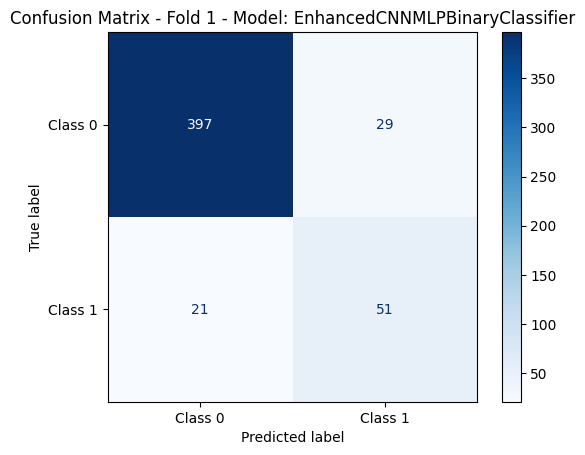


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Epoch [1/100], Train Loss: 0.6987, Val Loss: 0.6124, Train Acc: 0.5329, Val Acc: 0.7525
Epoch [2/100], Train Loss: 0.5784, Val Loss: 0.5199, Train Acc: 0.7318, Val Acc: 0.8652
Epoch [3/100], Train Loss: 0.5020, Val Loss: 0.4183, Train Acc: 0.8125, Val Acc: 0.9095
Epoch [4/100], Train Loss: 0.4451, Val Loss: 0.4127, Train Acc: 0.8595, Val Acc: 0.9034
Epoch [5/100], Train Loss: 0.3967, Val Loss: 0.3714, Train Acc: 0.8822, Val Acc: 0.9095
Epoch [6/100], Train Loss: 0.3786, Val Loss: 0.3601, Train Acc: 0.8812, Val Acc: 0.9135
Epoch [7/100], Train Loss: 0.3489, Val Loss: 0.3394, Train Acc: 0.8902, Val Acc: 0.9135
Epoch [8/100], Train Loss: 0.3239, Val Loss: 0.3114, Train Acc: 0.9035, Val Acc: 0.9215
Epoch [9/100], Train Loss: 0.3037, Val Loss: 0.3057, Train Acc: 0.8981, Val Acc: 0.9175
Epoch [10/100], Train Loss: 0.2998, Val Loss: 0.3128, Train Acc: 0.9000, Val Acc: 0.9135
Epoch [11/100], Train Loss: 0.2847, Val Loss

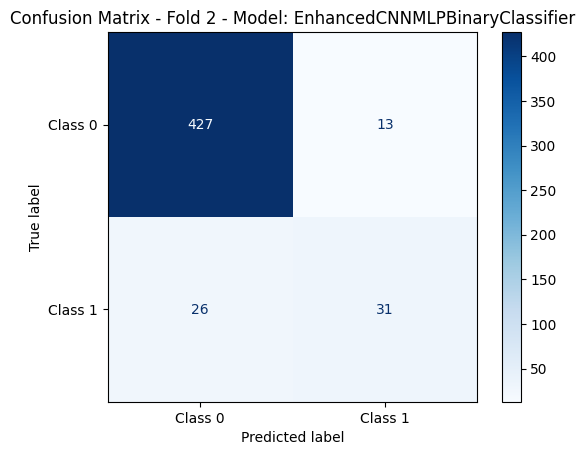


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Epoch [1/100], Train Loss: 0.5976, Val Loss: 0.5217, Train Acc: 0.6986, Val Acc: 0.8428
Epoch [2/100], Train Loss: 0.4976, Val Loss: 0.5093, Train Acc: 0.8168, Val Acc: 0.8665
Epoch [3/100], Train Loss: 0.4493, Val Loss: 0.4916, Train Acc: 0.8605, Val Acc: 0.8391
Epoch [4/100], Train Loss: 0.3889, Val Loss: 0.3609, Train Acc: 0.8884, Val Acc: 0.8867
Epoch [5/100], Train Loss: 0.3611, Val Loss: 0.3665, Train Acc: 0.8970, Val Acc: 0.8720
Epoch [6/100], Train Loss: 0.3335, Val Loss: 0.3357, Train Acc: 0.9051, Val Acc: 0.8885
Epoch [7/100], Train Loss: 0.3169, Val Loss: 0.3113, Train Acc: 0.9077, Val Acc: 0.8958
Epoch [8/100], Train Loss: 0.2981, Val Loss: 0.3329, Train Acc: 0.9036, Val Acc: 0.8885
Epoch [9/100], Train Loss: 0.2913, Val Loss: 0.3403, Train Acc: 0.9097, Val Acc: 0.8940
Epoch [10/100], Train Loss: 0.2809, Val Loss: 0.2940, Train Acc: 0.9046, Val Acc: 0.8958
Epoch [11/100], Train Loss: 0.2727, Val Loss

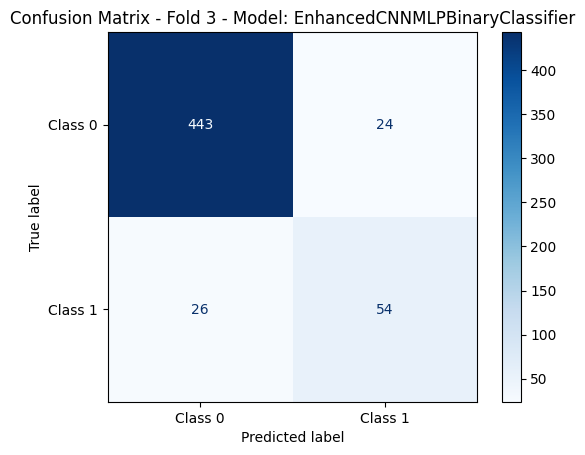


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Epoch [1/100], Train Loss: 0.5162, Val Loss: 0.5589, Train Acc: 0.8042, Val Acc: 0.8893
Epoch [2/100], Train Loss: 0.4341, Val Loss: 0.4548, Train Acc: 0.8673, Val Acc: 0.9150
Epoch [3/100], Train Loss: 0.3943, Val Loss: 0.4254, Train Acc: 0.8867, Val Acc: 0.9170
Epoch [4/100], Train Loss: 0.3668, Val Loss: 0.3919, Train Acc: 0.8847, Val Acc: 0.9170
Epoch [5/100], Train Loss: 0.3328, Val Loss: 0.3512, Train Acc: 0.9001, Val Acc: 0.9130
Epoch [6/100], Train Loss: 0.3152, Val Loss: 0.3290, Train Acc: 0.8996, Val Acc: 0.9150
Epoch [7/100], Train Loss: 0.3097, Val Loss: 0.3165, Train Acc: 0.9001, Val Acc: 0.9190
Epoch [8/100], Train Loss: 0.2937, Val Loss: 0.3250, Train Acc: 0.9026, Val Acc: 0.9150
Epoch [9/100], Train Loss: 0.2840, Val Loss: 0.2852, Train Acc: 0.9021, Val Acc: 0.9190
Epoch [10/100], Train Loss: 0.2646, Val Loss: 0.3053, Train Acc: 0.9051, Val Acc: 0.9190
Epoch [11/100], Train Loss: 0.2602, Val Loss

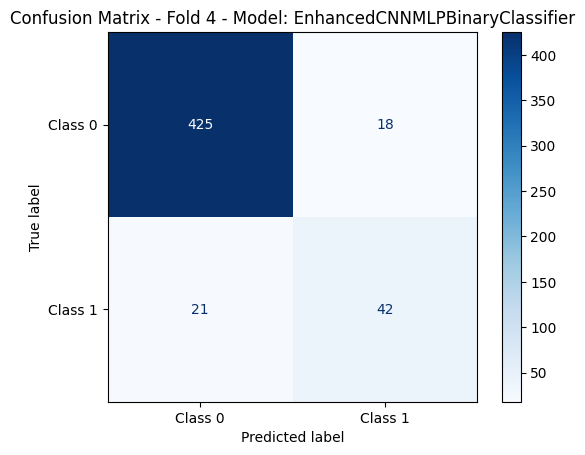


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Epoch [1/100], Train Loss: 0.7366, Val Loss: 0.6089, Train Acc: 0.4780, Val Acc: 0.7532
Epoch [2/100], Train Loss: 0.6044, Val Loss: 0.5110, Train Acc: 0.6978, Val Acc: 0.8702
Epoch [3/100], Train Loss: 0.5240, Val Loss: 0.4922, Train Acc: 0.7964, Val Acc: 0.8957
Epoch [4/100], Train Loss: 0.4666, Val Loss: 0.4226, Train Acc: 0.8442, Val Acc: 0.9043
Epoch [5/100], Train Loss: 0.4185, Val Loss: 0.3703, Train Acc: 0.8672, Val Acc: 0.9149
Epoch [6/100], Train Loss: 0.3864, Val Loss: 0.3406, Train Acc: 0.8828, Val Acc: 0.9234
Epoch [7/100], Train Loss: 0.3633, Val Loss: 0.3104, Train Acc: 0.8789, Val Acc: 0.9319
Epoch [8/100], Train Loss: 0.3357, Val Loss: 0.3404, Train Acc: 0.9004, Val Acc: 0.9213
Epoch [9/100], Train Loss: 0.3137, Val Loss: 0.2992, Train Acc: 0.8940, Val Acc: 0.9340
Epoch [10/100], Train Loss: 0.3112, Val Loss: 0.2928, Train Acc: 0.8979, Val Acc: 0.9340
Epoch [11/100], Train Loss: 0.2891, Val Loss

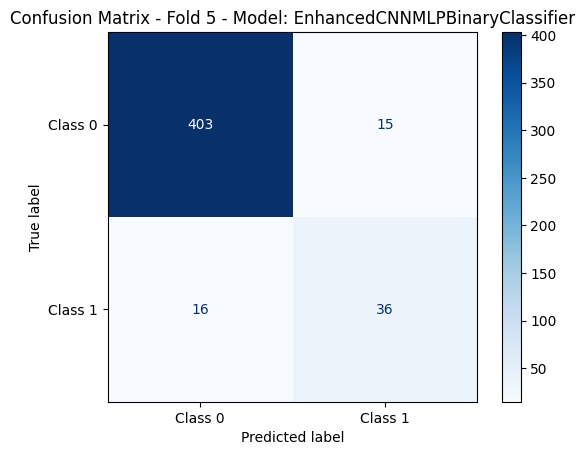


Model: EnhancedCNNMLPBinaryClassifier - Average Validation Accuracy: 0.9173
Average Precision: 0.6880
Average Recall: 0.6572
Average F1 Score: 0.6701
Average AUC-ROC: 0.9105

=== Benchmark Results ===

Model: EnhancedCNNMLPBinaryClassifier_Residual
Avg Validation Accuracy: 0.9178
Avg Precision: 0.7046
Avg Recall: 0.6227
Avg F1 Score: 0.6585
Avg AUC-ROC: 0.9151


Model: MLPBinaryClassifier
Avg Validation Accuracy: 0.9073
Avg Precision: 0.6297
Avg Recall: 0.6865
Avg F1 Score: 0.6549
Avg AUC-ROC: 0.9085


Model: ResidualMLPBinaryClassifier
Avg Validation Accuracy: 0.9192
Avg Precision: 0.7205
Avg Recall: 0.6010
Avg F1 Score: 0.6524
Avg AUC-ROC: 0.9227


Model: EnhancedCNNMLPBinaryClassifier
Avg Validation Accuracy: 0.9173
Avg Precision: 0.6880
Avg Recall: 0.6572
Avg F1 Score: 0.6701
Avg AUC-ROC: 0.9105




In [38]:
# List of model classes to benchmark
model_classes = [
    #EnhancedCNNMLPBinaryClassifier,
    EnhancedCNNMLPBinaryClassifier_Residual,
    MLPBinaryClassifier,
    ResidualMLPBinaryClassifier,
    EnhancedCNNMLPBinaryClassifier,
    #AdvancedCNNBinaryClassifier

]

# Run the benchmark on all models
results = benchmark_models(
    dataset=combined_dataset,
    df=df_Bintu,
    device=device,
    model_classes=model_classes,
    num_epochs=100,               # Use a lower number of epochs to start, increase if needed
    batch_size=16,
    learning_rate=0.0001,
    hidden_dim=64,               # ForA transformer or other models needing hidden dimension
    pos_weight=1,
    neg_weight=1,
    k_folds=5,
    augment_minority_class=True, # If your dataset is imbalanced
    weight_decay=0.01,
    patience=10
)

# Displaying benchmark results
print("\n=== Benchmark Results ===\n")
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("\n" + "="*30 + "\n")

In [77]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import copy

class EarlyStopping:
    """Early stops the training if validation F1 score doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation F1 improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation F1 improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model_wts = None

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            if self.verbose:
                print(f"Initial best F1 score set to: {self.best_score:.4f}")
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if self.verbose:
                print(f'Validation F1 improved from {self.best_score:.4f} to {score:.4f}. Resetting counter.')
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

def save_fold_data(fold, train_indices, train_ids, val_indices, val_ids, save_directory='saved_models'):
    """Save training and validation data (both indices and IDs) for each fold."""
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    fold_data = {
        'train_indices': train_indices,
        'train_ids': train_ids,
        'val_indices': val_indices,
        'val_ids': val_ids
    }
    with open(os.path.join(save_directory, f"fold_{fold + 1}_data.pkl"), "wb") as file:
        pickle.dump(fold_data, file)
    print(f"Training and validation data (indices and IDs) for Fold {fold + 1} saved.")

def benchmark_models(dataset, df, device, model_classes, num_epochs=10, batch_size=32,
                    learning_rate=1e-4, hidden_dim=64, pos_weight=1.0, neg_weight=1.0,
                    k_folds=5, sampling_method='none', weight_decay=0.0,
                    patience=10, save_directory='saved_models'):

    """
    Benchmark multiple models using Stratified K-Fold cross-validation with optional resampling.

    Parameters:
    - dataset: PyTorch Dataset object.
    - df: DataFrame containing metadata and labels.
    - device: Torch device ('cpu' or 'cuda').
    - model_classes: List of model classes to benchmark.
    - num_epochs: Number of training epochs.
    - batch_size: Batch size for DataLoaders.
    - learning_rate: Learning rate for optimizers.
    - hidden_dim: Hidden dimension size for certain models.
    - pos_weight: Weight for positive class in loss function.
    - neg_weight: Weight for negative class in loss function.
    - k_folds: Number of cross-validation folds.
    - sampling_method: 'none', 'oversample', or 'undersample'.
    - weight_decay: Weight decay (L2 regularization) factor.
    - patience: Patience for early stopping.
    - save_directory: Directory to save model weights.
    """

    # Ensure the save directory exists
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        print(f"Created directory for saving models: {save_directory}")

    # Determine input dimension from the first sample
    first_sequence, _, _ = dataset[0]
    input_dim = first_sequence.shape[-1]

    # Group indices by gene
    gene_to_indices = {}
    for idx, (_, _, gene_id) in enumerate(dataset):
        gene_name = gene_id.split("-")[0]
        if gene_name not in gene_to_indices:
            gene_to_indices[gene_name] = []
        gene_to_indices[gene_name].append(idx)

    # Assign class labels to genes based on majority class within each gene
    gene_classes = []
    for gene_name, indices in gene_to_indices.items():
        gene_ids = [dataset[i][2] for i in indices]
        class_labels = df[df['ID'].isin(gene_ids)]['Class']
        if class_labels.empty:
            majority_class = 0  # Default class if no labels are found
            print(f"Warning: No labels found for gene {gene_name}. Assigning default class 0.")
        else:
            majority_class = class_labels.mode()[0]
        gene_classes.append((gene_name, majority_class))

    gene_names, gene_labels = zip(*gene_classes)

    # Initialize Stratified K-Fold
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    all_results = {}

    for model_class in model_classes:
        print(f"\n=== Benchmarking Model: {model_class.__name__} ===\n")
        results = []

        for fold, (train_gene_idxs, val_gene_idxs) in enumerate(skf.split(gene_names, gene_labels)):
            print(f"\nFOLD {fold + 1}/{k_folds}")

            # Get gene names for training and validation
            train_genes = [gene_names[i] for i in train_gene_idxs]
            val_genes = [gene_names[i] for i in val_gene_idxs]

            # Get sample indices for training and validation
            train_indices = [idx for gene in train_genes for idx in gene_to_indices[gene]]
            val_indices = [idx for gene in val_genes for idx in gene_to_indices[gene]]

            # Get IDs for training and validation
            train_ids = [dataset[idx][2] for idx in train_indices]
            val_ids = [dataset[idx][2] for idx in val_indices]

            # Save fold data
            save_fold_data(fold, train_indices, train_ids, val_indices, val_ids, save_directory)

            # Create training and validation subsets
            train_subset = Subset(dataset, train_indices)
            val_subset = Subset(dataset, val_indices)

            # Extract features and labels from training subset
            X_train = []
            y_train = []
            for sample in train_subset:
                sequence, label, _ = sample
                X_train.append(sequence.numpy())
                y_train.append(label)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # Apply resampling if specified
            if sampling_method == 'oversample':
                print("Applying SMOTE oversampling to the training data.")
                smote = SMOTE(random_state=42)
                X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
            elif sampling_method == 'undersample':
                print("Applying Random Undersampling to the training data.")
                undersampler = RandomUnderSampler(random_state=42)
                X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)
            else:
                print("No resampling applied to the training data.")
                X_resampled, y_resampled = X_train, y_train

            # Create a new training subset after resampling
            X_resampled_tensor = torch.tensor(X_resampled, dtype=torch.float32)
            y_resampled_tensor = torch.tensor(y_resampled, dtype=torch.float32)
            train_dataset_resampled = TensorDataset(X_resampled_tensor, y_resampled_tensor)
            train_loader = DataLoader(train_dataset_resampled, batch_size=batch_size, shuffle=True)

            # Extract features and labels from validation subset
            X_val = []
            y_val = []
            for sample in val_subset:
                sequence, label, _ = sample
                X_val.append(sequence.numpy())
                y_val.append(label)
            X_val = np.array(X_val)
            y_val = np.array(y_val)
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
            val_dataset_tensor = TensorDataset(X_val_tensor, y_val_tensor)
            val_loader = DataLoader(val_dataset_tensor, batch_size=batch_size, shuffle=False)

            # Initialize the model with appropriate parameters
            if model_class.__name__ == "MLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dims=[128, 64, 32], dropout=0.4).to(device)
            elif model_class.__name__ == "AdvancedCNNBinaryClassifier":
                model = model_class(
                    input_dim=input_dim,
                    conv_out_channels=64,
                    hidden_dims=[128, 64],
                    dropout=0.3
                ).to(device)
            elif model_class.__name__ == "ResidualMLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dim=128, dropout=0.4).to(device)
            elif model_class.__name__ == "EnhancedCNNMLPBinaryClassifier":
                model = model_class(
                    input_dim=input_dim,
                    hidden_dims=[128, 64],
                    conv_out_channels=32,
                    kernel_size=3,
                    dropout=0.5
                ).to(device)
            elif model_class.__name__ == "EnhancedCNNMLPBinaryClassifier_Residual":
                model = model_class(
                    input_dim=input_dim,
                    hidden_dims=[128, 64],
                    conv_out_channels=32,
                    kernel_size=3,
                    dropout=0.5
                ).to(device)
            elif model_class.__name__ == "TransformerBinaryClassifier":
                model = model_class(
                    input_dim=input_dim,
                    hidden_dim=hidden_dim,
                    nhead=4,
                    num_layers=2,
                    dropout=0.5
                ).to(device)
            else:
                raise ValueError(f"Unknown model class: {model_class.__name__}")

            # Define loss function
            # Using BCEWithLogitsLoss for numerical stability and class weighting
            # If using BCELoss, ensure the model's final layer has a Sigmoid activation
            # Here, we'll proceed with BCELoss as per original code
            criterion = nn.BCELoss(reduction='mean')  # Consider using BCEWithLogitsLoss for better stability

            # Define optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            # Initialize EarlyStopping
            early_stopping = EarlyStopping(patience=patience, verbose=True)

            # Initialize variables for tracking best model
            best_val_f1 = 0.0

            # Lists to store training and validation metrics
            train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

            for epoch in range(num_epochs):
                model.train()
                train_loss, correct_train, total_train = 0, 0, 0

                for batch in train_loader:
                    sequences, labels = batch
                    sequences, labels = sequences.to(device), labels.to(device)

                    optimizer.zero_grad()

                    # Forward pass
                    outputs = model(sequences).squeeze(dim=1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    # Accumulate loss and accuracy
                    train_loss += loss.item() * sequences.size(0)
                    preds = (outputs > 0.5).float()
                    correct_train += (preds == labels).sum().item()
                    total_train += labels.size(0)

                # Calculate average training loss and accuracy
                train_losses.append(train_loss / total_train)
                train_accuracies.append(correct_train / total_train)

                # Validation phase
                model.eval()
                val_loss, correct_val, total_val = 0, 0, 0
                val_labels_list, val_preds_list, val_logits_list = [], [], []

                with torch.no_grad():
                    for batch in val_loader:
                        sequences, labels = batch
                        sequences, labels = sequences.to(device), labels.to(device)

                        outputs = model(sequences).squeeze(dim=1)
                        loss = nn.BCELoss()(outputs, labels)

                        val_loss += loss.item() * sequences.size(0)

                        predictions = (outputs > 0.5).float()

                        correct_val += (predictions == labels).sum().item()
                        total_val += labels.size(0)

                        val_labels_list.extend(labels.cpu().numpy())
                        val_preds_list.extend(predictions.cpu().numpy())
                        val_logits_list.extend(outputs.cpu().numpy())

                # Calculate average validation loss and accuracy
                val_losses.append(val_loss / total_val)
                val_accuracies.append(correct_val / total_val)

                # Calculate metrics
                precision = precision_score(val_labels_list, val_preds_list, zero_division=0)
                recall = recall_score(val_labels_list, val_preds_list, zero_division=0)
                f1 = f1_score(val_labels_list, val_preds_list, zero_division=0)
                auc_roc = roc_auc_score(val_labels_list, val_logits_list)

                print(f"Epoch [{epoch+1}/{num_epochs}], "
                      f"Train Loss: {train_losses[-1]:.4f}, "
                      f"Val Loss: {val_losses[-1]:.4f}, "
                      f"Train Acc: {train_accuracies[-1]:.4f}, "
                      f"Val Acc: {val_accuracies[-1]:.4f}")
                print(f"Fold {fold + 1} Epoch {epoch + 1} Metrics - "
                      f"Precision: {precision:.4f}, "
                      f"Recall: {recall:.4f}, "
                      f"F1 Score: {f1:.4f}, "
                      f"AUC-ROC: {auc_roc:.4f}")

                # Early stopping based on F1 score
                early_stopping(f1, model)
                if early_stopping.early_stop:
                    print(f"Early stopping triggered after {epoch+1} epochs.")
                    break

                # Update best validation F1 score
                if f1 > best_val_f1:
                    best_val_f1 = f1

            # After training, save the best model weights for this fold
            model_filename = f"{model_class.__name__}_fold{fold + 1}_weights.pth"
            model_path = os.path.join(save_directory, model_filename)
            torch.save(early_stopping.best_model_wts, model_path)
            print(f"Saved model weights for {model_class.__name__} Fold {fold + 1} at {model_path}")

            # Calculate final metrics for the fold
            precision = precision_score(val_labels_list, val_preds_list, zero_division=0)
            recall = recall_score(val_labels_list, val_preds_list, zero_division=0)
            f1 = f1_score(val_labels_list, val_preds_list, zero_division=0)
            auc_roc = roc_auc_score(val_labels_list, val_logits_list)

            print(f"Fold {fold + 1} Final Metrics - "
                  f"Precision: {precision:.4f}, "
                  f"Recall: {recall:.4f}, "
                  f"F1 Score: {f1:.4f}, "
                  f"AUC-ROC: {auc_roc:.4f}")

            # Plot Confusion Matrix
            cm = confusion_matrix(val_labels_list, val_preds_list)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
            disp.plot(cmap="Blues")
            plt.title(f'Confusion Matrix - Fold {fold + 1} - Model: {model_class.__name__}')
            plt.show()

            # Append results
            results.append({
                'Fold': fold + 1,
                'Validation Accuracy': val_accuracies[-1],
                'Validation Loss': val_losses[-1],
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'AUC-ROC': auc_roc
            })

        # Calculate average metrics across all folds
        avg_accuracy = np.mean([result['Validation Accuracy'] for result in results])
        avg_precision = np.mean([result['Precision'] for result in results])
        avg_recall = np.mean([result['Recall'] for result in results])
        avg_f1 = np.mean([result['F1 Score'] for result in results])
        avg_auc_roc = np.mean([result['AUC-ROC'] for result in results])

        print(f"\nModel: {model_class.__name__} - Average Validation Accuracy: {avg_accuracy:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print(f"Average Recall: {avg_recall:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print(f"Average AUC-ROC: {avg_auc_roc:.4f}")

        # Store results
        all_results[model_class.__name__] = {
            'Avg Validation Accuracy': avg_accuracy,
            'Avg Precision': avg_precision,
            'Avg Recall': avg_recall,
            'Avg F1 Score': avg_f1,
            'Avg AUC-ROC': avg_auc_roc
        }

    return all_results


In [66]:
data_rep = 'per_protein_embeddings_repression.h5'
data_act = 'per_protein_embeddings_activation_bintu.h5'
data_Bintu = 'BINTU_FULL.csv'
df_Bintu = pd.read_csv(data_Bintu)
df_Bintu = df_Bintu.drop(df_Bintu.columns[0], axis=1)
d_act = SequenceDataset(h5_file_path=data_act, df=df_Bintu)
d_rep = SequenceDataset(h5_file_path=data_rep, df=df_Bintu)
# Combine d_act and d_rep
combined_dataset = CombinedSequenceDataset(d_rep, d_act)

Using device: cuda
=== Benchmarking with No Resampling ===

=== Benchmarking Model: TransformerBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.5836, Val Loss: 0.4418, Train Acc: 0.7490, Val Acc: 0.8554
Fold 1 Epoch 1 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.5014
Initial best F1 score set to: 0.0000
Epoch [2/100], Train Loss: 0.4333, Val Loss: 0.4150, Train Acc: 0.8752, Val Acc: 0.8554
Fold 1 Epoch 2 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.5125
Validation F1 improved from 0.0000 to 0.0000. Resetting counter.
Epoch [3/100], Train Loss: 0.4117, Val Loss: 0.4241, Train Acc: 0.8752, Val Acc: 0.8554
Fold 1 Epoch 3 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.5693
Validation F1 improved from 0.0000 to 0.0000. Resetting counter.
Epoch [4/100], Train Loss: 0.3889, Val Loss: 0.4340

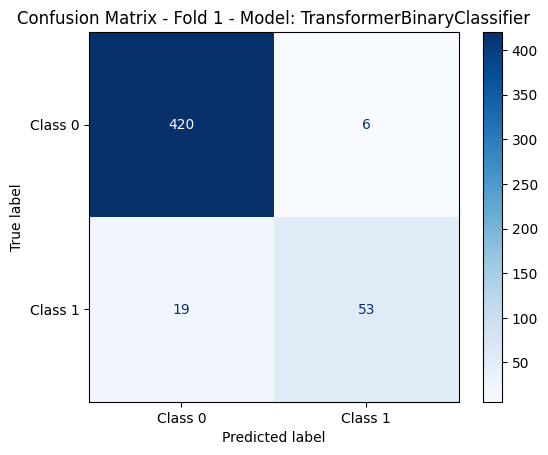


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.5800, Val Loss: 0.4264, Train Acc: 0.8288, Val Acc: 0.8853
Fold 2 Epoch 1 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.5028
Initial best F1 score set to: 0.0000
Epoch [2/100], Train Loss: 0.4509, Val Loss: 0.3583, Train Acc: 0.8679, Val Acc: 0.8853
Fold 2 Epoch 2 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.5222
Validation F1 improved from 0.0000 to 0.0000. Resetting counter.
Epoch [3/100], Train Loss: 0.4208, Val Loss: 0.3565, Train Acc: 0.8679, Val Acc: 0.8853
Fold 2 Epoch 3 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.5915
Validation F1 improved from 0.0000 to 0.0000. Resetting counter.
Epoch [4/100], Train Loss: 0.4073, Val Loss: 0.3586, Train Acc: 0.8679, Val Acc: 0.8853
Fold 2 Epoch 4 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AU

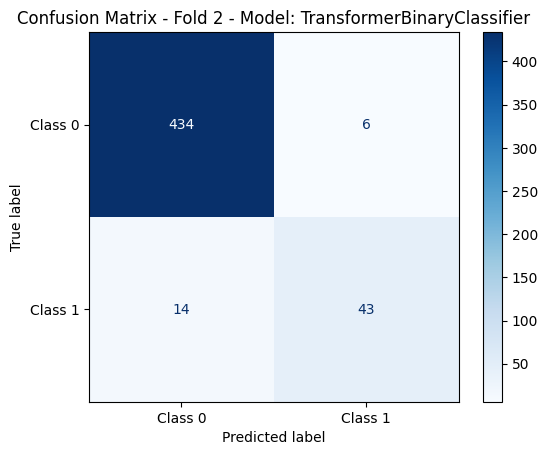


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.5676, Val Loss: 0.4463, Train Acc: 0.8047, Val Acc: 0.8537
Fold 3 Epoch 1 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.5325
Initial best F1 score set to: 0.0000
Epoch [2/100], Train Loss: 0.4248, Val Loss: 0.4198, Train Acc: 0.8762, Val Acc: 0.8537
Fold 3 Epoch 2 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.5545
Validation F1 improved from 0.0000 to 0.0000. Resetting counter.
Epoch [3/100], Train Loss: 0.4009, Val Loss: 0.4313, Train Acc: 0.8762, Val Acc: 0.8537
Fold 3 Epoch 3 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.6600
Validation F1 improved from 0.0000 to 0.0000. Resetting counter.
Epoch [4/100], Train Loss: 0.4026, Val Loss: 0.4262, Train Acc: 0.8762, Val Acc: 0.8537
Fold 3 Epoch 4 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AU

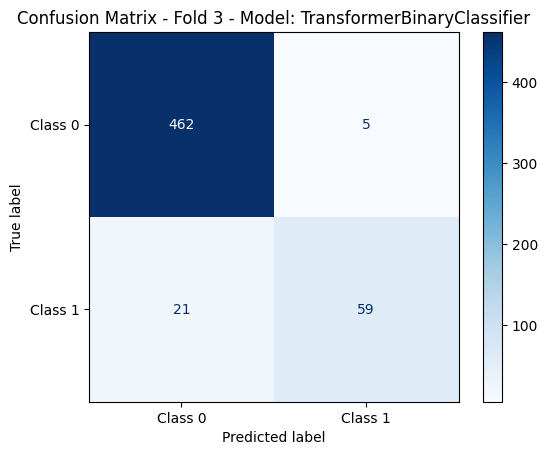


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.5788, Val Loss: 0.4248, Train Acc: 0.7758, Val Acc: 0.8755
Fold 4 Epoch 1 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.4672
Initial best F1 score set to: 0.0000
Epoch [2/100], Train Loss: 0.4337, Val Loss: 0.3762, Train Acc: 0.8698, Val Acc: 0.8755
Fold 4 Epoch 2 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.4840
Validation F1 improved from 0.0000 to 0.0000. Resetting counter.
Epoch [3/100], Train Loss: 0.4098, Val Loss: 0.3801, Train Acc: 0.8703, Val Acc: 0.8755
Fold 4 Epoch 3 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.5246
Validation F1 improved from 0.0000 to 0.0000. Resetting counter.
Epoch [4/100], Train Loss: 0.4032, Val Loss: 0.3812, Train Acc: 0.8703, Val Acc: 0.8755
Fold 4 Epoch 4 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AU

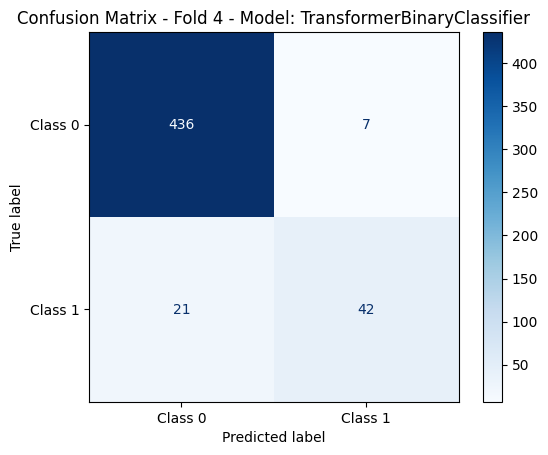


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.5220, Val Loss: 0.3732, Train Acc: 0.8462, Val Acc: 0.8894
Fold 5 Epoch 1 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.4935
Initial best F1 score set to: 0.0000
Epoch [2/100], Train Loss: 0.4157, Val Loss: 0.3478, Train Acc: 0.8672, Val Acc: 0.8894
Fold 5 Epoch 2 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.5449
Validation F1 improved from 0.0000 to 0.0000. Resetting counter.
Epoch [3/100], Train Loss: 0.4067, Val Loss: 0.3484, Train Acc: 0.8672, Val Acc: 0.8894
Fold 5 Epoch 3 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.6321
Validation F1 improved from 0.0000 to 0.0000. Resetting counter.
Epoch [4/100], Train Loss: 0.3996, Val Loss: 0.3481, Train Acc: 0.8672, Val Acc: 0.8894
Fold 5 Epoch 4 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AU

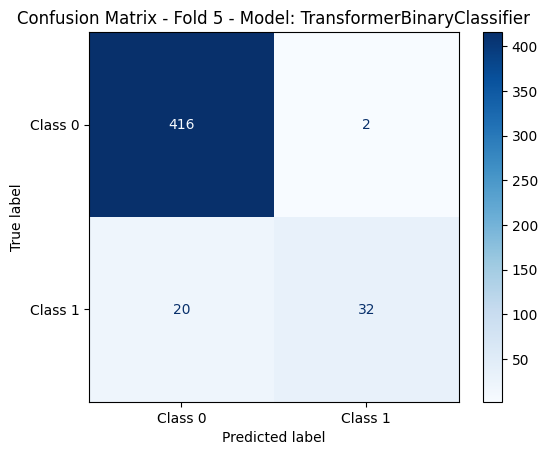


Model: TransformerBinaryClassifier - Average Validation Accuracy: 0.9520
Average Precision: 0.8992
Average Recall: 0.7020
Average F1 Score: 0.7868
Average AUC-ROC: 0.9619

=== Comparison of Benchmarking Results ===
No Resampling: {'TransformerBinaryClassifier': {'Avg Validation Accuracy': 0.9519762552779731, 'Avg Precision': 0.8992100865770037, 'Avg Recall': 0.7020096716149349, 'Avg F1 Score': 0.786822310203313, 'Avg AUC-ROC': 0.961915525170918}}


In [90]:

# Example: Loading your dataset and DataFrame
# Replace with your actual data loading logic
# For demonstration, let's assume `combined_dataset` is your dataset object and `df_Bintu` is your DataFrame
# combined_dataset = YourCustomDataset(...)
# df_Bintu = pd.read_csv('your_data.csv')

# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the list of model classes to benchmark
model_classes = [
    #EnhancedCNNMLPBinaryClassifier_Residual,
    #MLPBinaryClassifier,
    #ResidualMLPBinaryClassifier,
    #EnhancedCNNMLPBinaryClassifier,
    # Add other model classes as needed
    TransformerBinaryClassifier
]

# Benchmark with no resampling
print("=== Benchmarking with No Resampling ===")
results_no_resampling = benchmark_models(
    dataset=combined_dataset,
    df=df_Bintu,
    device=device,
    model_classes=model_classes,
    num_epochs=100,
    batch_size=32,
    learning_rate=1e-4,
    hidden_dim=64,
    pos_weight=1.0,
    neg_weight=1.0,
    k_folds=5,
    sampling_method='none',  # Options: 'none', 'oversample', 'undersample'
    weight_decay=1e-5,
    patience=10,
    save_directory='saved_models/Bintu_2/no_resampling'
)

# # Benchmark with SMOTE oversampling
# print("\n=== Benchmarking with SMOTE Oversampling ===")
# results_oversample = benchmark_models(
#     dataset=combined_dataset,
#     df=df_Bintu,
#     device=device,
#     model_classes=model_classes,
#     num_epochs=100,
#     batch_size=32,
#     learning_rate=1e-4,
#     hidden_dim=64,
#     pos_weight=1.0,
#     neg_weight=1.0,
#     k_folds=5,
#     sampling_method='oversample',  # Options: 'none', 'oversample', 'undersample'
#     weight_decay=1e-5,
#     patience=10,
#     save_directory='saved_models/oversampling'
# )

# # Benchmark with Random Undersampling
# print("\n=== Benchmarking with Random Undersampling ===")
# results_undersample = benchmark_models(
#     dataset=combined_dataset,
#     df=df_Bintu,
#     device=device,
#     model_classes=model_classes,
#     num_epochs=100,
#     batch_size=32,
#     learning_rate=1e-4,
#     hidden_dim=64,
#     pos_weight=1.0,
#     neg_weight=1.0,
#     k_folds=5,
#     sampling_method='undersample',  # Options: 'none', 'oversample', 'undersample'
#     weight_decay=1e-5,
#     patience=10,
#     save_directory='saved_models/undersampling'
# )

# Optionally, compare results
print("\n=== Comparison of Benchmarking Results ===")
print("No Resampling:", results_no_resampling)
# print("Oversampling:", results_oversample)
# print("Undersampling:", results_undersample)


Implement on Isoforms Datset

In [68]:
import torch
import h5py
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, h5_file_path, df, class_col='Class', standardize=True):
        """
        Initializes the dataset by creating a list of embeddings and class labels from the HDF5 file and DataFrame.

        Parameters:
        - h5_file_path: Path to the HDF5 file containing protein embeddings.
        - df: DataFrame containing protein IDs and class labels.
        - class_col: Column name for the label. Defaults to 'Class'.
        - standardize: Whether to standardize embeddings to zero mean and unit variance. Defaults to True.
        """
        self.data = []
        embeddings = []

        # Load the HDF5 file
        with h5py.File(h5_file_path, "r") as h5_file:
            # Filter protein IDs to include only those present in the DataFrame's "ID" column
            valid_protein_ids = set(df['ID']).intersection(h5_file.keys())

            # Collect embeddings to calculate mean and std if standardization is needed
            for protein_id in valid_protein_ids:
                embedding = h5_file[protein_id][()]
                embeddings.append(embedding)

        # Standardize if needed
        if standardize:
            embeddings = torch.tensor(embeddings, dtype=torch.float)
            self.mean = embeddings.mean(dim=0)
            self.std = embeddings.std(dim=0)
            self.std[self.std == 0] = 1  # Prevent division by zero

        # Load data with standardization if applicable
        with h5py.File(h5_file_path, "r") as h5_file:
            for protein_id in valid_protein_ids:
                embedding = torch.tensor(h5_file[protein_id][()], dtype=torch.float)
                if standardize:
                    embedding = (embedding - self.mean) / self.std  # Standardize

                # Get the class label from the DataFrame
                label = torch.tensor(df.loc[df['ID'] == protein_id, class_col].values[0], dtype=torch.float)

                # Append the embedding, label, and protein ID as a dictionary
                self.data.append({'embedding': embedding, 'label': label, 'ID': protein_id})

    def __len__(self):
        # Return the number of embeddings
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve a single embedding and its label
        data = self.data[idx]
        return data['embedding'], data['label'], data['ID']


In [69]:
df_iso = pd.read_csv("ISO_FULL.CSV")
df_iso.head()

,ID,REP_Q2,REP_N2,REP_S2,REP_G2,REP_E2,REP_D2,REP_K2,REP_R2,REP_P2,...,net_charge,WF_complexity,KL_hydropathy,isoelectric_point,FCR,ED_ratio,RK_ratio,SCD,omega*,Class
0,ARNT2-1,1.309662,-0.618361,2.397098,-0.383163,-0.660254,0.761530,0.217436,1.618940,0.285942,...,-0.381542,0.947422,0.086818,-0.520538,-0.570053,-0.362143,0.635850,-0.098020,0.075008,1
1,ARNT2-2,1.309662,-0.618361,2.397098,-0.383163,-0.660254,0.761530,0.217436,1.618940,-0.248339,...,0.205181,0.887692,0.080876,0.343694,-0.548616,-0.255840,0.686459,-0.088509,-0.492538,1
2,ATF2-2,0.200936,-0.618361,1.682995,-0.916464,0.293757,1.575578,1.366979,0.897295,-0.515480,...,-0.014840,-0.239688,0.131963,-0.204469,-0.472345,-0.156335,-0.351880,-0.219513,-1.391212,1
3,ATF2-5,-0.242554,-0.618361,-0.221281,-0.916464,-0.183249,0.761530,0.217436,-1.267640,-0.782620,...,-0.234861,-0.461494,0.377617,-0.791120,0.032233,-0.504160,-1.311613,-0.034336,-1.361816,1
4,CREB1-1,0.200936,0.371597,0.016753,-0.383163,0.770763,-0.866568,-0.357336,0.897295,-0.782620,...,-0.234861,-0.562249,0.441422,-1.004554,-0.573718,0.559435,0.101002,-0.179989,0.781130,1


In [73]:
dataset = SequenceDataset(h5_file_path="per_protein_embeddings.h5", df=df_iso)


Run experiments

Using device: cuda
=== Benchmarking with No Resampling ===
Created directory for saving models: saved_models/Isoforms/noresampling

=== Benchmarking Model: EnhancedCNNMLPBinaryClassifier_Residual ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.6837, Val Loss: 0.6821, Train Acc: 0.5971, Val Acc: 0.6618
Fold 1 Epoch 1 Metrics - Precision: 0.8667, Recall: 0.6964, F1 Score: 0.7723, AUC-ROC: 0.5193
Initial best F1 score set to: 0.7723
Epoch [2/100], Train Loss: 0.6329, Val Loss: 0.6699, Train Acc: 0.6703, Val Acc: 0.6912
Fold 1 Epoch 2 Metrics - Precision: 0.8723, Recall: 0.7321, F1 Score: 0.7961, AUC-ROC: 0.4985
Validation F1 improved from 0.7723 to 0.7961. Resetting counter.
Epoch [3/100], Train Loss: 0.5971, Val Loss: 0.6504, Train Acc: 0.7436, Val Acc: 0.7500
Fold 1 Epoch 3 Metrics - Precision: 0.8824, Recall: 0.8036, F1 Score: 0.8411, AUC-ROC: 0.4985
Validation F1 improved from 0.79

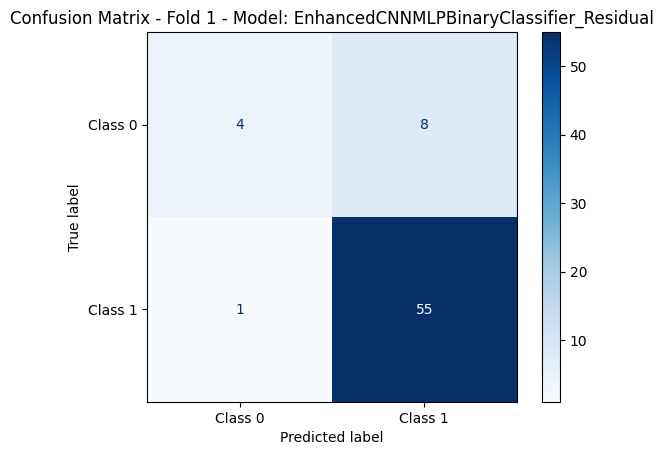


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.7314, Val Loss: 0.6793, Train Acc: 0.5055, Val Acc: 0.6857
Fold 2 Epoch 1 Metrics - Precision: 0.9535, Recall: 0.6721, F1 Score: 0.7885, AUC-ROC: 0.8616
Initial best F1 score set to: 0.7885
Epoch [2/100], Train Loss: 0.6576, Val Loss: 0.6627, Train Acc: 0.6458, Val Acc: 0.7714
Fold 2 Epoch 2 Metrics - Precision: 0.9592, Recall: 0.7705, F1 Score: 0.8545, AUC-ROC: 0.8743
Validation F1 improved from 0.7885 to 0.8545. Resetting counter.
Epoch [3/100], Train Loss: 0.6458, Val Loss: 0.6388, Train Acc: 0.6531, Val Acc: 0.8286
Fold 2 Epoch 3 Metrics - Precision: 0.9623, Recall: 0.8361, F1 Score: 0.8947, AUC-ROC: 0.8962
Validation F1 improved from 0.8545 to 0.8947. Resetting counter.
Epoch [4/100], Train Loss: 0.6251, Val Loss: 0.6087, Train Acc: 0.6900, Val Acc: 0.8429
Fold 2 Epoch 4 Metrics - Precision: 0.9630, Recall: 0.8525, F1 Score: 0.9043, AU

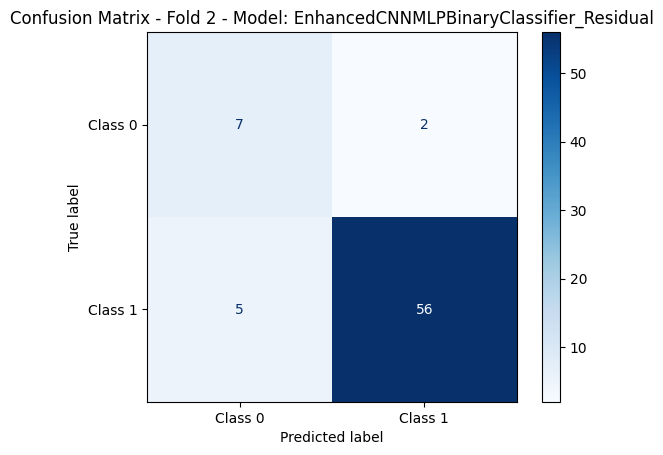


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.7289, Val Loss: 0.6523, Train Acc: 0.5273, Val Acc: 0.8333
Fold 3 Epoch 1 Metrics - Precision: 0.9259, Recall: 0.8772, F1 Score: 0.9009, AUC-ROC: 0.8207
Initial best F1 score set to: 0.9009
Epoch [2/100], Train Loss: 0.6885, Val Loss: 0.6068, Train Acc: 0.6291, Val Acc: 0.8788
Fold 3 Epoch 2 Metrics - Precision: 0.9016, Recall: 0.9649, F1 Score: 0.9322, AUC-ROC: 0.7992
Validation F1 improved from 0.9009 to 0.9322. Resetting counter.
Epoch [3/100], Train Loss: 0.6590, Val Loss: 0.5916, Train Acc: 0.6291, Val Acc: 0.8939
Fold 3 Epoch 3 Metrics - Precision: 0.9032, Recall: 0.9825, F1 Score: 0.9412, AUC-ROC: 0.7466
Validation F1 improved from 0.9322 to 0.9412. Resetting counter.
Epoch [4/100], Train Loss: 0.6403, Val Loss: 0.5972, Train Acc: 0.7273, Val Acc: 0.8939
Fold 3 Epoch 4 Metrics - Precision: 0.9032, Recall: 0.9825, F1 Score: 0.9412, AU

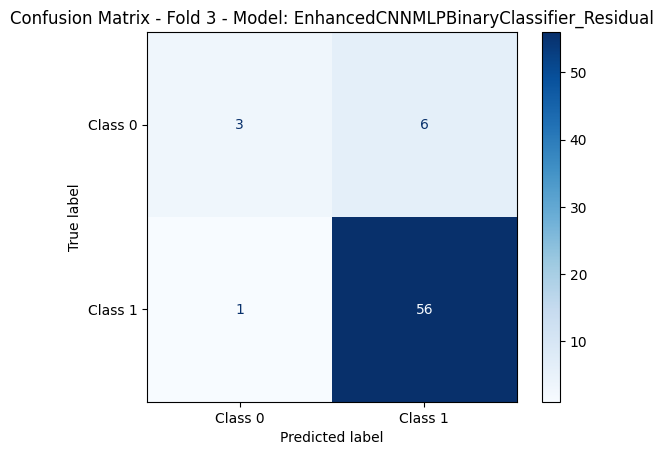


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.5950, Val Loss: 0.6371, Train Acc: 0.7243, Val Acc: 0.7536
Fold 4 Epoch 1 Metrics - Precision: 0.9583, Recall: 0.7541, F1 Score: 0.8440, AUC-ROC: 0.8217
Initial best F1 score set to: 0.8440
Epoch [2/100], Train Loss: 0.5643, Val Loss: 0.5285, Train Acc: 0.7647, Val Acc: 0.8986
Fold 4 Epoch 2 Metrics - Precision: 0.9655, Recall: 0.9180, F1 Score: 0.9412, AUC-ROC: 0.7766
Validation F1 improved from 0.8440 to 0.9412. Resetting counter.
Epoch [3/100], Train Loss: 0.5185, Val Loss: 0.4870, Train Acc: 0.8235, Val Acc: 0.9275
Fold 4 Epoch 3 Metrics - Precision: 0.9667, Recall: 0.9508, F1 Score: 0.9587, AUC-ROC: 0.7746
Validation F1 improved from 0.9412 to 0.9587. Resetting counter.
Epoch [4/100], Train Loss: 0.5040, Val Loss: 0.4932, Train Acc: 0.8456, Val Acc: 0.9130
Fold 4 Epoch 4 Metrics - Precision: 0.9661, Recall: 0.9344, F1 Score: 0.9500, AU

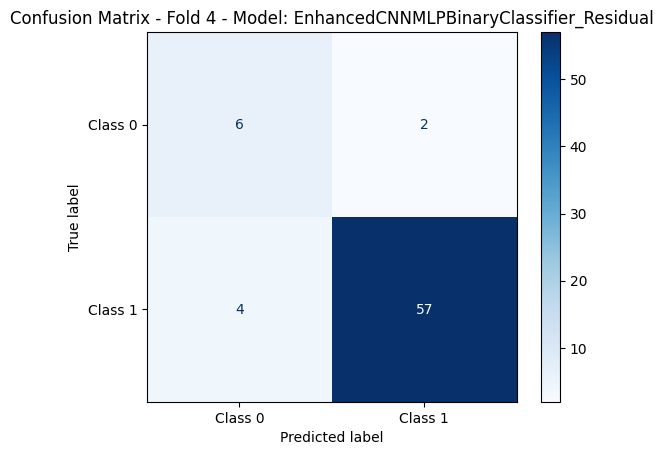


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.6718, Val Loss: 0.6926, Train Acc: 0.5934, Val Acc: 0.6471
Fold 5 Epoch 1 Metrics - Precision: 0.9091, Recall: 0.6667, F1 Score: 0.7692, AUC-ROC: 0.6708
Initial best F1 score set to: 0.7692
Epoch [2/100], Train Loss: 0.6002, Val Loss: 0.6714, Train Acc: 0.7143, Val Acc: 0.6912
Fold 5 Epoch 2 Metrics - Precision: 0.9149, Recall: 0.7167, F1 Score: 0.8037, AUC-ROC: 0.6396
Validation F1 improved from 0.7692 to 0.8037. Resetting counter.
Epoch [3/100], Train Loss: 0.5854, Val Loss: 0.6448, Train Acc: 0.7436, Val Acc: 0.7647
Fold 5 Epoch 3 Metrics - Precision: 0.9231, Recall: 0.8000, F1 Score: 0.8571, AUC-ROC: 0.6458
Validation F1 improved from 0.8037 to 0.8571. Resetting counter.
Epoch [4/100], Train Loss: 0.5342, Val Loss: 0.6051, Train Acc: 0.8242, Val Acc: 0.8088
Fold 5 Epoch 4 Metrics - Precision: 0.9273, Recall: 0.8500, F1 Score: 0.8870, AU

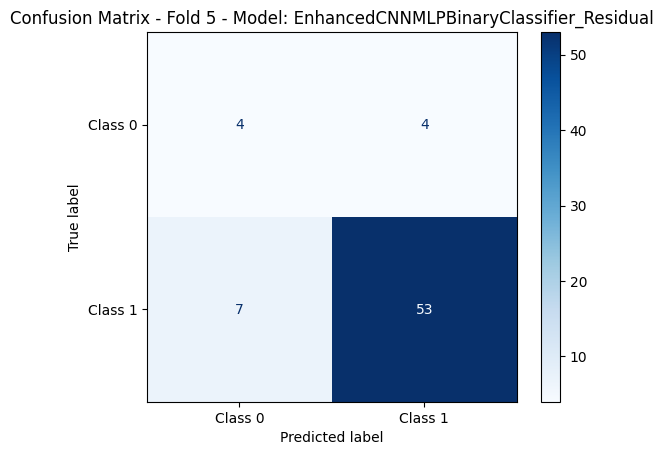


Model: EnhancedCNNMLPBinaryClassifier_Residual - Average Validation Accuracy: 0.8826
Average Precision: 0.9275
Average Recall: 0.9401
Average F1 Score: 0.9325
Average AUC-ROC: 0.7998

=== Benchmarking Model: MLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.7387, Val Loss: 0.6710, Train Acc: 0.4835, Val Acc: 0.6176
Fold 1 Epoch 1 Metrics - Precision: 0.8000, Recall: 0.7143, F1 Score: 0.7547, AUC-ROC: 0.3304
Initial best F1 score set to: 0.7547
Epoch [2/100], Train Loss: 0.6640, Val Loss: 0.6180, Train Acc: 0.5788, Val Acc: 0.7206
Fold 1 Epoch 2 Metrics - Precision: 0.8033, Recall: 0.8750, F1 Score: 0.8376, AUC-ROC: 0.4494
Validation F1 improved from 0.7547 to 0.8376. Resetting counter.
Epoch [3/100], Train Loss: 0.5920, Val Loss: 0.5746, Train Acc: 0.7143, Val Acc: 0.7500
Fold 1 Epoch 3 Metrics - Precision: 0.8095, Recall: 0.9107, F1 Score: 0.8571, AUC-ROC: 0.4762

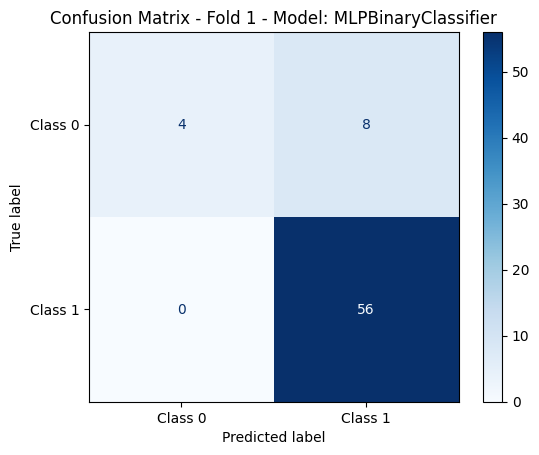


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.7043, Val Loss: 0.6363, Train Acc: 0.4945, Val Acc: 0.6571
Fold 2 Epoch 1 Metrics - Precision: 0.8491, Recall: 0.7377, F1 Score: 0.7895, AUC-ROC: 0.5337
Initial best F1 score set to: 0.7895
Epoch [2/100], Train Loss: 0.6353, Val Loss: 0.5525, Train Acc: 0.6236, Val Acc: 0.8571
Fold 2 Epoch 2 Metrics - Precision: 0.9048, Recall: 0.9344, F1 Score: 0.9194, AUC-ROC: 0.7814
Validation F1 improved from 0.7895 to 0.9194. Resetting counter.
Epoch [3/100], Train Loss: 0.5993, Val Loss: 0.4972, Train Acc: 0.7417, Val Acc: 0.9143
Fold 2 Epoch 3 Metrics - Precision: 0.9365, Recall: 0.9672, F1 Score: 0.9516, AUC-ROC: 0.8470
Validation F1 improved from 0.9194 to 0.9516. Resetting counter.
Epoch [4/100], Train Loss: 0.5497, Val Loss: 0.4590, Train Acc: 0.8007, Val Acc: 0.9286
Fold 2 Epoch 4 Metrics - Precision: 0.9516, Recall: 0.9672, F1 Score: 0.9593, AU

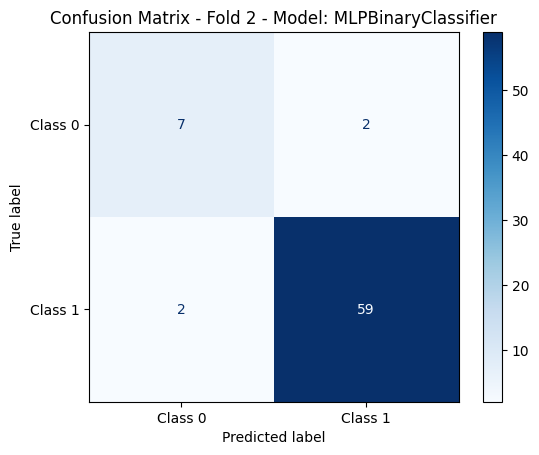


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.7624, Val Loss: 0.6419, Train Acc: 0.4255, Val Acc: 0.8030
Fold 3 Epoch 1 Metrics - Precision: 0.9583, Recall: 0.8070, F1 Score: 0.8762, AUC-ROC: 0.7388
Initial best F1 score set to: 0.8762
Epoch [2/100], Train Loss: 0.6566, Val Loss: 0.5745, Train Acc: 0.6036, Val Acc: 0.8485
Fold 3 Epoch 2 Metrics - Precision: 0.8852, Recall: 0.9474, F1 Score: 0.9153, AUC-ROC: 0.7544
Validation F1 improved from 0.8762 to 0.9153. Resetting counter.
Epoch [3/100], Train Loss: 0.6201, Val Loss: 0.5303, Train Acc: 0.6836, Val Acc: 0.8788
Fold 3 Epoch 3 Metrics - Precision: 0.8769, Recall: 1.0000, F1 Score: 0.9344, AUC-ROC: 0.7427
Validation F1 improved from 0.9153 to 0.9344. Resetting counter.
Epoch [4/100], Train Loss: 0.6177, Val Loss: 0.5030, Train Acc: 0.6764, Val Acc: 0.8788
Fold 3 Epoch 4 Metrics - Precision: 0.8769, Recall: 1.0000, F1 Score: 0.9344, AU

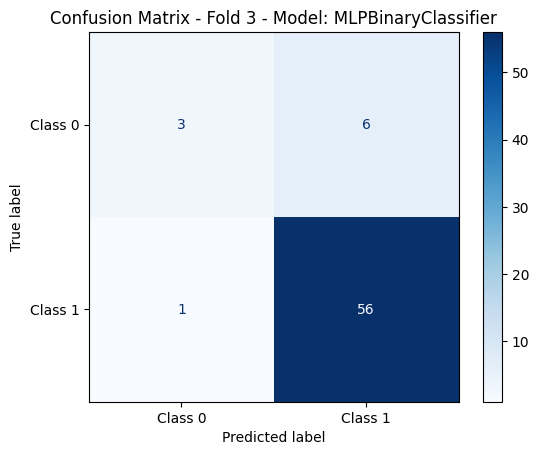


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.6186, Val Loss: 0.5623, Train Acc: 0.6875, Val Acc: 0.8406
Fold 4 Epoch 1 Metrics - Precision: 0.9310, Recall: 0.8852, F1 Score: 0.9076, AUC-ROC: 0.6865
Initial best F1 score set to: 0.9076
Epoch [2/100], Train Loss: 0.5926, Val Loss: 0.5012, Train Acc: 0.7279, Val Acc: 0.8841
Fold 4 Epoch 2 Metrics - Precision: 0.9344, Recall: 0.9344, F1 Score: 0.9344, AUC-ROC: 0.7316
Validation F1 improved from 0.9076 to 0.9344. Resetting counter.
Epoch [3/100], Train Loss: 0.5424, Val Loss: 0.4625, Train Acc: 0.7904, Val Acc: 0.9275
Fold 4 Epoch 3 Metrics - Precision: 0.9375, Recall: 0.9836, F1 Score: 0.9600, AUC-ROC: 0.7459
Validation F1 improved from 0.9344 to 0.9600. Resetting counter.
Epoch [4/100], Train Loss: 0.4995, Val Loss: 0.4304, Train Acc: 0.8272, Val Acc: 0.9275
Fold 4 Epoch 4 Metrics - Precision: 0.9375, Recall: 0.9836, F1 Score: 0.9600, AU

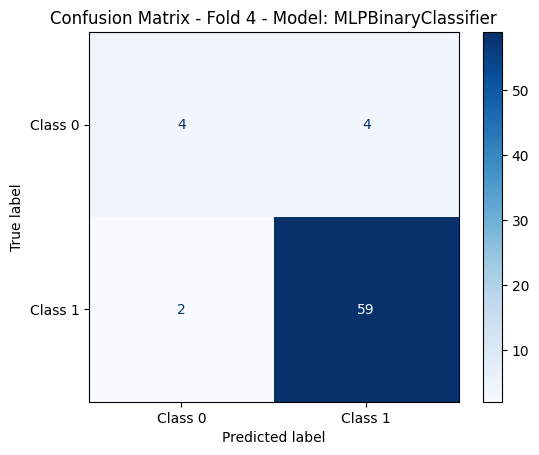


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.6801, Val Loss: 0.5236, Train Acc: 0.5934, Val Acc: 0.8529
Fold 5 Epoch 1 Metrics - Precision: 0.8906, Recall: 0.9500, F1 Score: 0.9194, AUC-ROC: 0.8625
Initial best F1 score set to: 0.9194
Epoch [2/100], Train Loss: 0.6099, Val Loss: 0.4813, Train Acc: 0.6960, Val Acc: 0.8824
Fold 5 Epoch 2 Metrics - Precision: 0.9333, Recall: 0.9333, F1 Score: 0.9333, AUC-ROC: 0.8208
Validation F1 improved from 0.9194 to 0.9333. Resetting counter.
Epoch [3/100], Train Loss: 0.5541, Val Loss: 0.4527, Train Acc: 0.7802, Val Acc: 0.8824
Fold 5 Epoch 3 Metrics - Precision: 0.9333, Recall: 0.9333, F1 Score: 0.9333, AUC-ROC: 0.8000
Validation F1 improved from 0.9333 to 0.9333. Resetting counter.
Epoch [4/100], Train Loss: 0.5251, Val Loss: 0.4300, Train Acc: 0.8132, Val Acc: 0.8824
Fold 5 Epoch 4 Metrics - Precision: 0.9333, Recall: 0.9333, F1 Score: 0.9333, AU

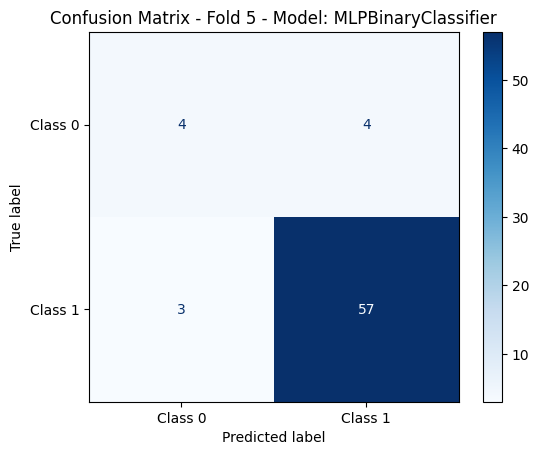


Model: MLPBinaryClassifier - Average Validation Accuracy: 0.9059
Average Precision: 0.9233
Average Recall: 0.9734
Average F1 Score: 0.9471
Average AUC-ROC: 0.7976

=== Benchmarking Model: ResidualMLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.4846, Val Loss: 0.4682, Train Acc: 0.7802, Val Acc: 0.8235
Fold 1 Epoch 1 Metrics - Precision: 0.8235, Recall: 1.0000, F1 Score: 0.9032, AUC-ROC: 0.7098
Initial best F1 score set to: 0.9032
Epoch [2/100], Train Loss: 0.3022, Val Loss: 0.5150, Train Acc: 0.8938, Val Acc: 0.8235
Fold 1 Epoch 2 Metrics - Precision: 0.8235, Recall: 1.0000, F1 Score: 0.9032, AUC-ROC: 0.7262
Validation F1 improved from 0.9032 to 0.9032. Resetting counter.
Epoch [3/100], Train Loss: 0.2790, Val Loss: 0.5323, Train Acc: 0.8938, Val Acc: 0.8088
Fold 1 Epoch 3 Metrics - Precision: 0.8209, Recall: 0.9821, F1 Score: 0.8943, AUC-ROC: 0.7202
EarlyStoppi

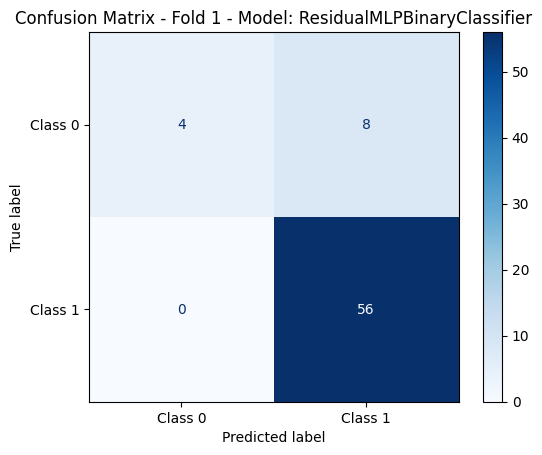


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.4230, Val Loss: 0.2890, Train Acc: 0.8524, Val Acc: 0.8714
Fold 2 Epoch 1 Metrics - Precision: 0.8714, Recall: 1.0000, F1 Score: 0.9313, AUC-ROC: 0.8179
Initial best F1 score set to: 0.9313
Epoch [2/100], Train Loss: 0.3273, Val Loss: 0.2706, Train Acc: 0.8782, Val Acc: 0.9286
Fold 2 Epoch 2 Metrics - Precision: 0.9516, Recall: 0.9672, F1 Score: 0.9593, AUC-ROC: 0.8051
Validation F1 improved from 0.9313 to 0.9593. Resetting counter.
Epoch [3/100], Train Loss: 0.2872, Val Loss: 0.2633, Train Acc: 0.8819, Val Acc: 0.9286
Fold 2 Epoch 3 Metrics - Precision: 0.9516, Recall: 0.9672, F1 Score: 0.9593, AUC-ROC: 0.7996
Validation F1 improved from 0.9593 to 0.9593. Resetting counter.
Epoch [4/100], Train Loss: 0.2435, Val Loss: 0.2578, Train Acc: 0.9041, Val Acc: 0.9286
Fold 2 Epoch 4 Metrics - Precision: 0.9516, Recall: 0.9672, F1 Score: 0.9593, AU

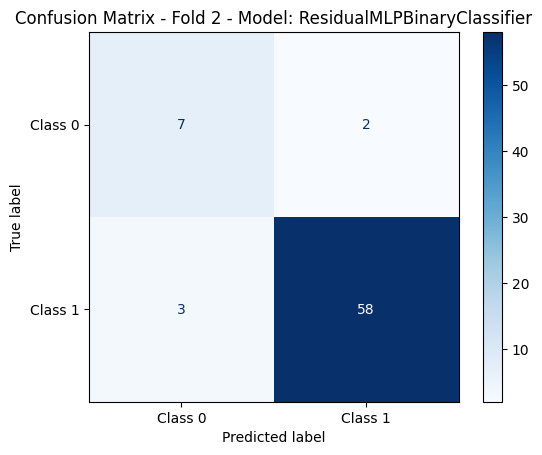


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 1.1921, Val Loss: 0.5131, Train Acc: 0.3273, Val Acc: 0.8333
Fold 3 Epoch 1 Metrics - Precision: 0.8966, Recall: 0.9123, F1 Score: 0.9043, AUC-ROC: 0.6842
Initial best F1 score set to: 0.9043
Epoch [2/100], Train Loss: 0.5068, Val Loss: 0.3451, Train Acc: 0.7709, Val Acc: 0.8636
Fold 3 Epoch 2 Metrics - Precision: 0.8636, Recall: 1.0000, F1 Score: 0.9268, AUC-ROC: 0.7349
Validation F1 improved from 0.9043 to 0.9268. Resetting counter.
Epoch [3/100], Train Loss: 0.3574, Val Loss: 0.3762, Train Acc: 0.8655, Val Acc: 0.8636
Fold 3 Epoch 3 Metrics - Precision: 0.8636, Recall: 1.0000, F1 Score: 0.9268, AUC-ROC: 0.7368
Validation F1 improved from 0.9268 to 0.9268. Resetting counter.
Epoch [4/100], Train Loss: 0.2908, Val Loss: 0.4058, Train Acc: 0.8727, Val Acc: 0.8636
Fold 3 Epoch 4 Metrics - Precision: 0.8636, Recall: 1.0000, F1 Score: 0.9268, AU

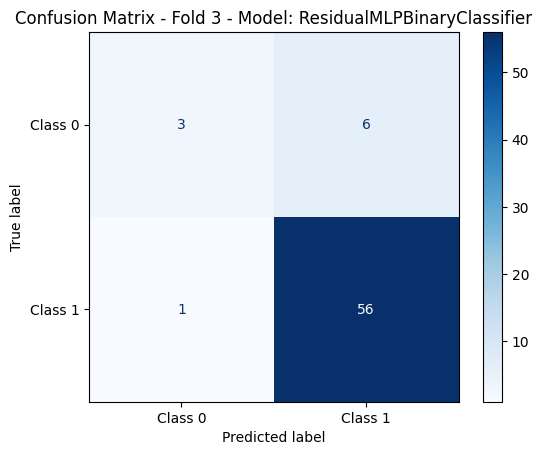


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.5566, Val Loss: 0.3091, Train Acc: 0.7353, Val Acc: 0.8551
Fold 4 Epoch 1 Metrics - Precision: 0.8806, Recall: 0.9672, F1 Score: 0.9219, AUC-ROC: 0.8586
Initial best F1 score set to: 0.9219
Epoch [2/100], Train Loss: 0.3876, Val Loss: 0.2577, Train Acc: 0.8529, Val Acc: 0.8841
Fold 4 Epoch 2 Metrics - Precision: 0.8841, Recall: 1.0000, F1 Score: 0.9385, AUC-ROC: 0.8689
Validation F1 improved from 0.9219 to 0.9385. Resetting counter.
Epoch [3/100], Train Loss: 0.3230, Val Loss: 0.2304, Train Acc: 0.8676, Val Acc: 0.9275
Fold 4 Epoch 3 Metrics - Precision: 0.9375, Recall: 0.9836, F1 Score: 0.9600, AUC-ROC: 0.8709
Validation F1 improved from 0.9385 to 0.9600. Resetting counter.
Epoch [4/100], Train Loss: 0.3096, Val Loss: 0.2182, Train Acc: 0.8824, Val Acc: 0.9275
Fold 4 Epoch 4 Metrics - Precision: 0.9375, Recall: 0.9836, F1 Score: 0.9600, AU

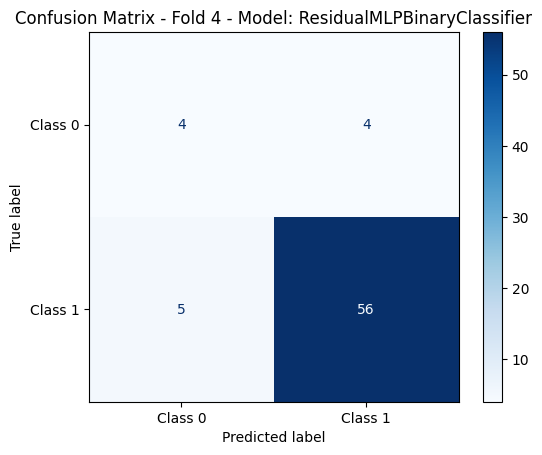


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 1.1128, Val Loss: 0.5864, Train Acc: 0.3590, Val Acc: 0.6765
Fold 5 Epoch 1 Metrics - Precision: 0.9318, Recall: 0.6833, F1 Score: 0.7885, AUC-ROC: 0.7583
Initial best F1 score set to: 0.7885
Epoch [2/100], Train Loss: 0.5222, Val Loss: 0.3242, Train Acc: 0.7766, Val Acc: 0.9118
Fold 5 Epoch 2 Metrics - Precision: 0.9219, Recall: 0.9833, F1 Score: 0.9516, AUC-ROC: 0.7688
Validation F1 improved from 0.7885 to 0.9516. Resetting counter.
Epoch [3/100], Train Loss: 0.3348, Val Loss: 0.2931, Train Acc: 0.8791, Val Acc: 0.9118
Fold 5 Epoch 3 Metrics - Precision: 0.9091, Recall: 1.0000, F1 Score: 0.9524, AUC-ROC: 0.7792
Validation F1 improved from 0.9516 to 0.9524. Resetting counter.
Epoch [4/100], Train Loss: 0.3225, Val Loss: 0.2880, Train Acc: 0.8755, Val Acc: 0.9118
Fold 5 Epoch 4 Metrics - Precision: 0.9091, Recall: 1.0000, F1 Score: 0.9524, AU

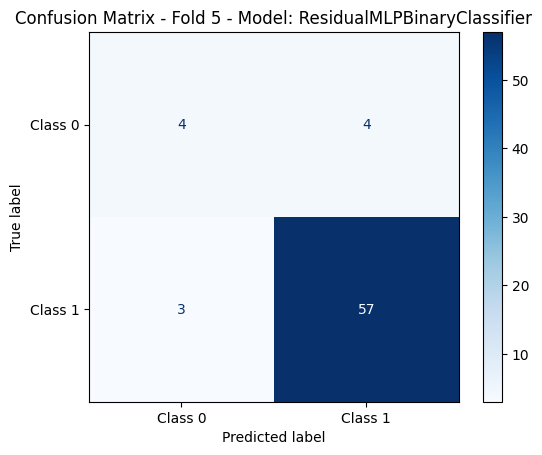


Model: ResidualMLPBinaryClassifier - Average Validation Accuracy: 0.8943
Average Precision: 0.9225
Average Recall: 0.9603
Average F1 Score: 0.9402
Average AUC-ROC: 0.8360

=== Benchmarking Model: EnhancedCNNMLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.7578, Val Loss: 0.7203, Train Acc: 0.4322, Val Acc: 0.1912
Fold 1 Epoch 1 Metrics - Precision: 1.0000, Recall: 0.0179, F1 Score: 0.0351, AUC-ROC: 0.5238
Initial best F1 score set to: 0.0351
Epoch [2/100], Train Loss: 0.7096, Val Loss: 0.7110, Train Acc: 0.5824, Val Acc: 0.4118
Fold 1 Epoch 2 Metrics - Precision: 0.7857, Recall: 0.3929, F1 Score: 0.5238, AUC-ROC: 0.5402
Validation F1 improved from 0.0351 to 0.5238. Resetting counter.
Epoch [3/100], Train Loss: 0.7057, Val Loss: 0.6940, Train Acc: 0.5311, Val Acc: 0.7206
Fold 1 Epoch 3 Metrics - Precision: 0.8776, Recall: 0.7679, F1 Score: 0.8190, AUC-ROC: 0.5402


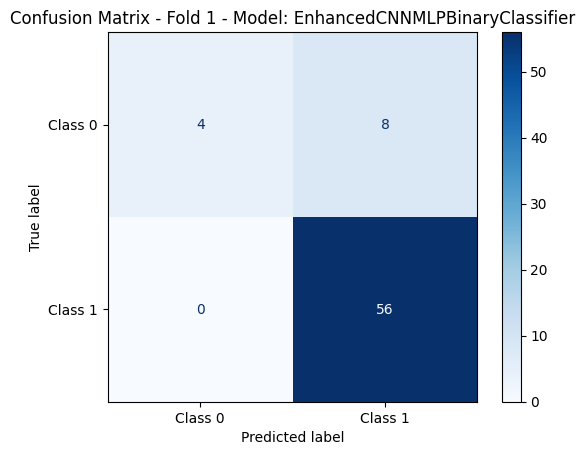


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.7007, Val Loss: 0.6706, Train Acc: 0.5609, Val Acc: 0.8000
Fold 2 Epoch 1 Metrics - Precision: 0.9608, Recall: 0.8033, F1 Score: 0.8750, AUC-ROC: 0.8215
Initial best F1 score set to: 0.8750
Epoch [2/100], Train Loss: 0.6978, Val Loss: 0.6169, Train Acc: 0.5572, Val Acc: 0.8143
Fold 2 Epoch 2 Metrics - Precision: 0.9615, Recall: 0.8197, F1 Score: 0.8850, AUC-ROC: 0.7559
Validation F1 improved from 0.8750 to 0.8850. Resetting counter.
Epoch [3/100], Train Loss: 0.6993, Val Loss: 0.5697, Train Acc: 0.6384, Val Acc: 0.8714
Fold 2 Epoch 3 Metrics - Precision: 0.9643, Recall: 0.8852, F1 Score: 0.9231, AUC-ROC: 0.7559
Validation F1 improved from 0.8850 to 0.9231. Resetting counter.
Epoch [4/100], Train Loss: 0.6493, Val Loss: 0.5479, Train Acc: 0.6421, Val Acc: 0.9143
Fold 2 Epoch 4 Metrics - Precision: 0.9661, Recall: 0.9344, F1 Score: 0.9500, AU

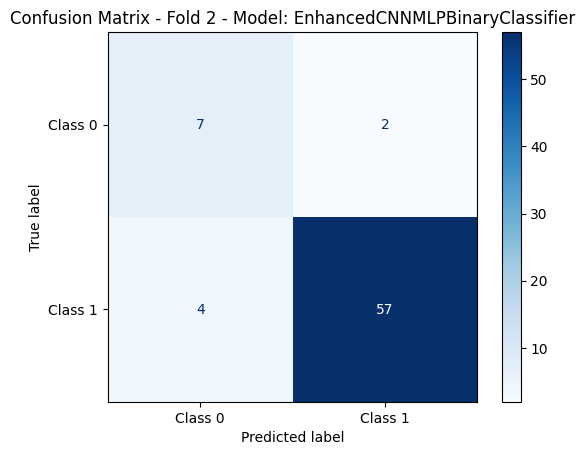


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.7255, Val Loss: 0.6390, Train Acc: 0.5309, Val Acc: 0.8636
Fold 3 Epoch 1 Metrics - Precision: 0.8636, Recall: 1.0000, F1 Score: 0.9268, AUC-ROC: 0.6764
Initial best F1 score set to: 0.9268
Epoch [2/100], Train Loss: 0.6796, Val Loss: 0.6255, Train Acc: 0.5527, Val Acc: 0.8939
Fold 3 Epoch 2 Metrics - Precision: 0.8906, Recall: 1.0000, F1 Score: 0.9421, AUC-ROC: 0.6725
Validation F1 improved from 0.9268 to 0.9421. Resetting counter.
Epoch [3/100], Train Loss: 0.6536, Val Loss: 0.5955, Train Acc: 0.6545, Val Acc: 0.9091
Fold 3 Epoch 3 Metrics - Precision: 0.9048, Recall: 1.0000, F1 Score: 0.9500, AUC-ROC: 0.6413
Validation F1 improved from 0.9421 to 0.9500. Resetting counter.
Epoch [4/100], Train Loss: 0.6399, Val Loss: 0.5969, Train Acc: 0.6545, Val Acc: 0.8788
Fold 3 Epoch 4 Metrics - Precision: 0.8769, Recall: 1.0000, F1 Score: 0.9344, AU

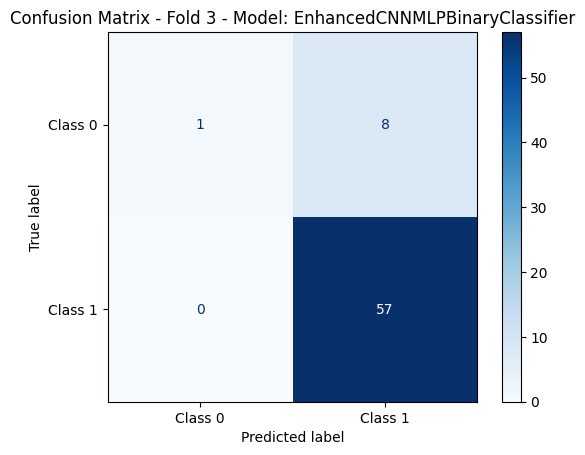


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.7142, Val Loss: 0.7406, Train Acc: 0.5184, Val Acc: 0.1159
Fold 4 Epoch 1 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.8627
Initial best F1 score set to: 0.0000
Epoch [2/100], Train Loss: 0.6645, Val Loss: 0.6709, Train Acc: 0.6360, Val Acc: 0.7246
Fold 4 Epoch 2 Metrics - Precision: 0.9565, Recall: 0.7213, F1 Score: 0.8224, AUC-ROC: 0.8197
Validation F1 improved from 0.0000 to 0.8224. Resetting counter.
Epoch [3/100], Train Loss: 0.6446, Val Loss: 0.6114, Train Acc: 0.6360, Val Acc: 0.8551
Fold 4 Epoch 3 Metrics - Precision: 0.9636, Recall: 0.8689, F1 Score: 0.9138, AUC-ROC: 0.8217
Validation F1 improved from 0.8224 to 0.9138. Resetting counter.
Epoch [4/100], Train Loss: 0.6556, Val Loss: 0.5793, Train Acc: 0.6654, Val Acc: 0.9275
Fold 4 Epoch 4 Metrics - Precision: 0.9667, Recall: 0.9508, F1 Score: 0.9587, AU

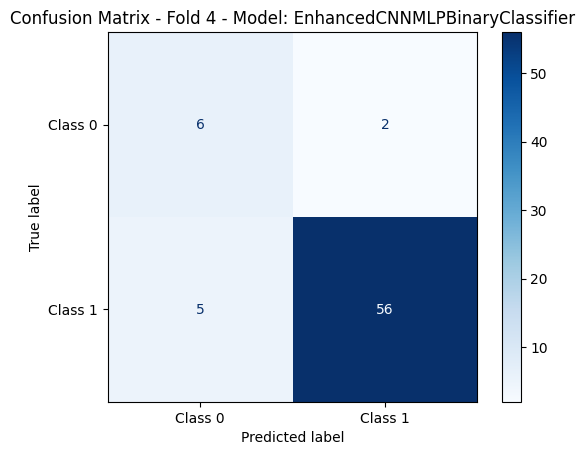


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.7375, Val Loss: 0.6963, Train Acc: 0.5055, Val Acc: 0.4706
Fold 5 Epoch 1 Metrics - Precision: 0.9286, Recall: 0.4333, F1 Score: 0.5909, AUC-ROC: 0.7312
Initial best F1 score set to: 0.5909
Epoch [2/100], Train Loss: 0.7079, Val Loss: 0.6860, Train Acc: 0.5421, Val Acc: 0.6912
Fold 5 Epoch 2 Metrics - Precision: 0.9333, Recall: 0.7000, F1 Score: 0.8000, AUC-ROC: 0.7292
Validation F1 improved from 0.5909 to 0.8000. Resetting counter.
Epoch [3/100], Train Loss: 0.6739, Val Loss: 0.6548, Train Acc: 0.5714, Val Acc: 0.7794
Fold 5 Epoch 3 Metrics - Precision: 0.9245, Recall: 0.8167, F1 Score: 0.8673, AUC-ROC: 0.7229
Validation F1 improved from 0.8000 to 0.8673. Resetting counter.
Epoch [4/100], Train Loss: 0.6481, Val Loss: 0.6212, Train Acc: 0.6374, Val Acc: 0.7794
Fold 5 Epoch 4 Metrics - Precision: 0.9245, Recall: 0.8167, F1 Score: 0.8673, AU

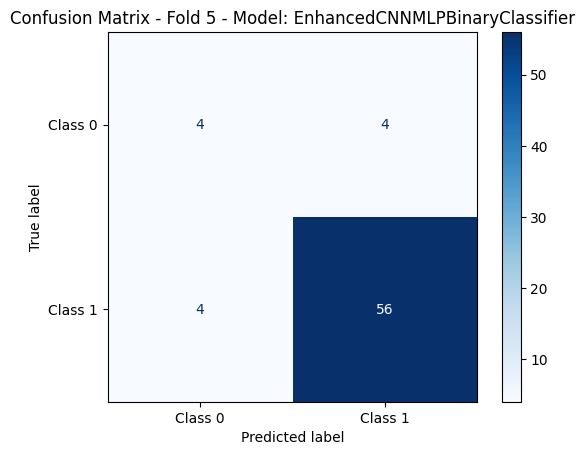


Model: EnhancedCNNMLPBinaryClassifier - Average Validation Accuracy: 0.8913
Average Precision: 0.9234
Average Recall: 0.9572
Average F1 Score: 0.9385
Average AUC-ROC: 0.7586

=== Benchmarking Model: TransformerBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.7067, Val Loss: 0.6764, Train Acc: 0.4249, Val Acc: 0.8235
Fold 1 Epoch 1 Metrics - Precision: 0.8235, Recall: 1.0000, F1 Score: 0.9032, AUC-ROC: 0.4464
Initial best F1 score set to: 0.9032
Epoch [2/100], Train Loss: 0.6688, Val Loss: 0.6393, Train Acc: 0.6081, Val Acc: 0.8235
Fold 1 Epoch 2 Metrics - Precision: 0.8235, Recall: 1.0000, F1 Score: 0.9032, AUC-ROC: 0.4702
Validation F1 improved from 0.9032 to 0.9032. Resetting counter.
Epoch [3/100], Train Loss: 0.6374, Val Loss: 0.6105, Train Acc: 0.7436, Val Acc: 0.8235
Fold 1 Epoch 3 Metrics - Precision: 0.8235, Recall: 1.0000, F1 Score: 0.9032, AUC-ROC: 0.5283


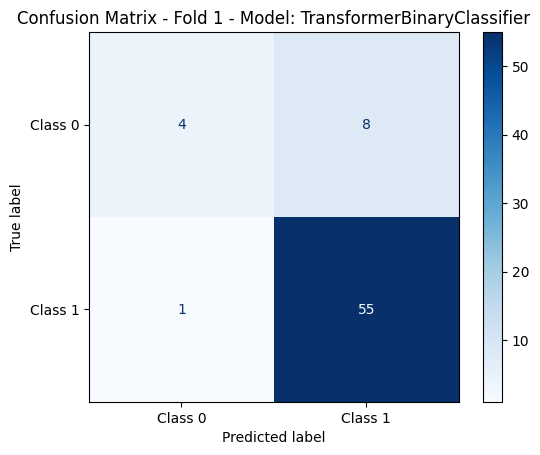


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.6473, Val Loss: 0.6069, Train Acc: 0.7048, Val Acc: 0.8714
Fold 2 Epoch 1 Metrics - Precision: 0.8714, Recall: 1.0000, F1 Score: 0.9313, AUC-ROC: 0.3333
Initial best F1 score set to: 0.9313
Epoch [2/100], Train Loss: 0.6064, Val Loss: 0.5584, Train Acc: 0.7970, Val Acc: 0.8714
Fold 2 Epoch 2 Metrics - Precision: 0.8714, Recall: 1.0000, F1 Score: 0.9313, AUC-ROC: 0.5519
Validation F1 improved from 0.9313 to 0.9313. Resetting counter.
Epoch [3/100], Train Loss: 0.5590, Val Loss: 0.5200, Train Acc: 0.8708, Val Acc: 0.8714
Fold 2 Epoch 3 Metrics - Precision: 0.8714, Recall: 1.0000, F1 Score: 0.9313, AUC-ROC: 0.7031
Validation F1 improved from 0.9313 to 0.9313. Resetting counter.
Epoch [4/100], Train Loss: 0.5453, Val Loss: 0.4889, Train Acc: 0.8524, Val Acc: 0.8714
Fold 2 Epoch 4 Metrics - Precision: 0.8714, Recall: 1.0000, F1 Score: 0.9313, AU

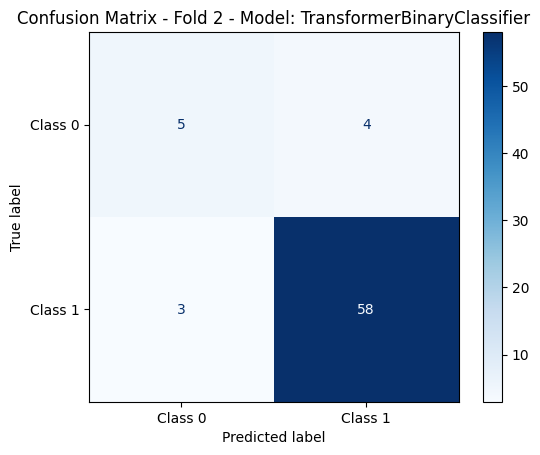


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.6989, Val Loss: 0.6318, Train Acc: 0.4618, Val Acc: 0.8636
Fold 3 Epoch 1 Metrics - Precision: 0.8636, Recall: 1.0000, F1 Score: 0.9268, AUC-ROC: 0.3606
Initial best F1 score set to: 0.9268
Epoch [2/100], Train Loss: 0.6500, Val Loss: 0.5829, Train Acc: 0.6618, Val Acc: 0.8636
Fold 3 Epoch 2 Metrics - Precision: 0.8636, Recall: 1.0000, F1 Score: 0.9268, AUC-ROC: 0.5419
Validation F1 improved from 0.9268 to 0.9268. Resetting counter.
Epoch [3/100], Train Loss: 0.6043, Val Loss: 0.5421, Train Acc: 0.8036, Val Acc: 0.8636
Fold 3 Epoch 3 Metrics - Precision: 0.8636, Recall: 1.0000, F1 Score: 0.9268, AUC-ROC: 0.6257
Validation F1 improved from 0.9268 to 0.9268. Resetting counter.
Epoch [4/100], Train Loss: 0.5786, Val Loss: 0.5090, Train Acc: 0.8291, Val Acc: 0.8636
Fold 3 Epoch 4 Metrics - Precision: 0.8636, Recall: 1.0000, F1 Score: 0.9268, AU

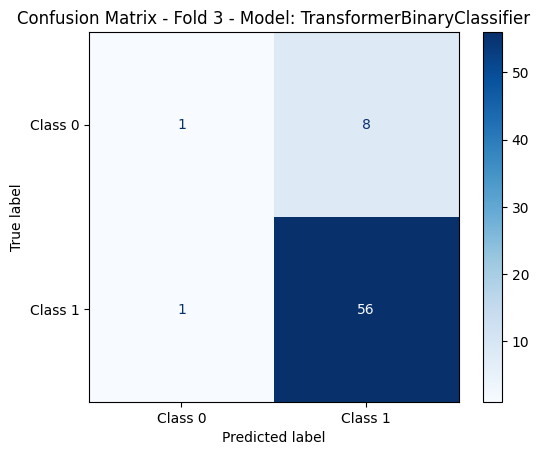


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.7257, Val Loss: 0.6892, Train Acc: 0.3676, Val Acc: 0.5942
Fold 4 Epoch 1 Metrics - Precision: 0.9714, Recall: 0.5574, F1 Score: 0.7083, AUC-ROC: 0.8545
Initial best F1 score set to: 0.7083
Epoch [2/100], Train Loss: 0.6915, Val Loss: 0.6193, Train Acc: 0.5588, Val Acc: 0.9275
Fold 4 Epoch 2 Metrics - Precision: 0.9375, Recall: 0.9836, F1 Score: 0.9600, AUC-ROC: 0.8955
Validation F1 improved from 0.7083 to 0.9600. Resetting counter.
Epoch [3/100], Train Loss: 0.6429, Val Loss: 0.5738, Train Acc: 0.7316, Val Acc: 0.8841
Fold 4 Epoch 3 Metrics - Precision: 0.8841, Recall: 1.0000, F1 Score: 0.9385, AUC-ROC: 0.9221
EarlyStopping counter: 1 out of 10
Epoch [4/100], Train Loss: 0.6111, Val Loss: 0.5404, Train Acc: 0.8015, Val Acc: 0.8841
Fold 4 Epoch 4 Metrics - Precision: 0.8841, Recall: 1.0000, F1 Score: 0.9385, AUC-ROC: 0.9221
EarlyStopping co

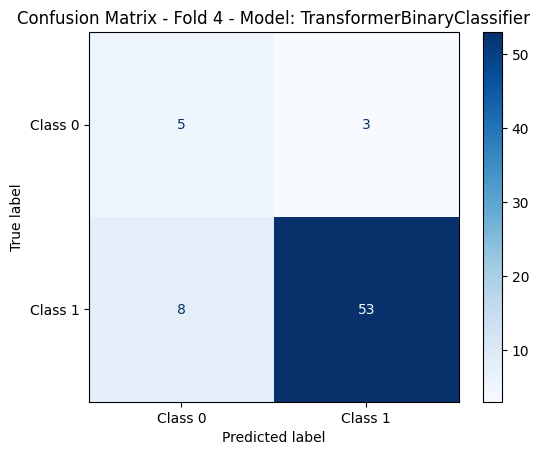


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
No resampling applied to the training data.
Epoch [1/100], Train Loss: 0.6692, Val Loss: 0.6257, Train Acc: 0.6264, Val Acc: 0.8824
Fold 5 Epoch 1 Metrics - Precision: 0.8824, Recall: 1.0000, F1 Score: 0.9375, AUC-ROC: 0.8062
Initial best F1 score set to: 0.9375
Epoch [2/100], Train Loss: 0.6380, Val Loss: 0.5944, Train Acc: 0.7656, Val Acc: 0.8824
Fold 5 Epoch 2 Metrics - Precision: 0.8824, Recall: 1.0000, F1 Score: 0.9375, AUC-ROC: 0.7958
Validation F1 improved from 0.9375 to 0.9375. Resetting counter.
Epoch [3/100], Train Loss: 0.6120, Val Loss: 0.5694, Train Acc: 0.8168, Val Acc: 0.8824
Fold 5 Epoch 3 Metrics - Precision: 0.8824, Recall: 1.0000, F1 Score: 0.9375, AUC-ROC: 0.7604
Validation F1 improved from 0.9375 to 0.9375. Resetting counter.
Epoch [4/100], Train Loss: 0.5971, Val Loss: 0.5468, Train Acc: 0.8388, Val Acc: 0.8824
Fold 5 Epoch 4 Metrics - Precision: 0.8824, Recall: 1.0000, F1 Score: 0.9375, AU

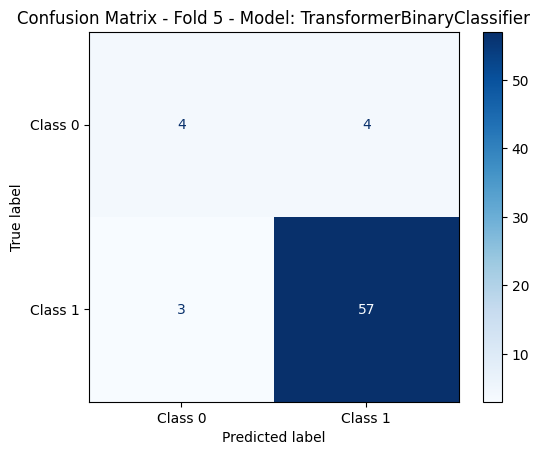


Model: TransformerBinaryClassifier - Average Validation Accuracy: 0.8738
Average Precision: 0.9129
Average Recall: 0.9469
Average F1 Score: 0.9282
Average AUC-ROC: 0.6864

=== Benchmarking with SMOTE Oversampling ===

=== Benchmarking Model: EnhancedCNNMLPBinaryClassifier_Residual ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6138, Val Loss: 0.6216, Train Acc: 0.6695, Val Acc: 0.8088
Fold 1 Epoch 1 Metrics - Precision: 0.8909, Recall: 0.8750, F1 Score: 0.8829, AUC-ROC: 0.6652
Initial best F1 score set to: 0.8829
Epoch [2/100], Train Loss: 0.5090, Val Loss: 0.5120, Train Acc: 0.7866, Val Acc: 0.8235
Fold 1 Epoch 2 Metrics - Precision: 0.8793, Recall: 0.9107, F1 Score: 0.8947, AUC-ROC: 0.7470
Validation F1 improved from 0.8829 to 0.8947. Resetting counter.
Epoch [3/100], Train Loss: 0.4440, Val Loss: 0.4850, Train Acc: 0.8661, Val Acc: 0.8235
Fold 1 Epoch 3 Metrics - Precisio

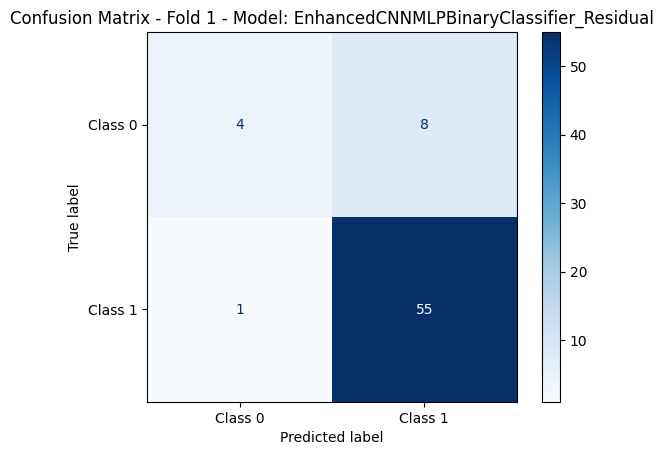


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6330, Val Loss: 0.6373, Train Acc: 0.6154, Val Acc: 0.6571
Fold 2 Epoch 1 Metrics - Precision: 0.9512, Recall: 0.6393, F1 Score: 0.7647, AUC-ROC: 0.8087
Initial best F1 score set to: 0.7647
Epoch [2/100], Train Loss: 0.5288, Val Loss: 0.5474, Train Acc: 0.7756, Val Acc: 0.8714
Fold 2 Epoch 2 Metrics - Precision: 0.9643, Recall: 0.8852, F1 Score: 0.9231, AUC-ROC: 0.8251
Validation F1 improved from 0.7647 to 0.9231. Resetting counter.
Epoch [3/100], Train Loss: 0.4919, Val Loss: 0.5235, Train Acc: 0.8226, Val Acc: 0.8857
Fold 2 Epoch 3 Metrics - Precision: 0.9649, Recall: 0.9016, F1 Score: 0.9322, AUC-ROC: 0.8397
Validation F1 improved from 0.9231 to 0.9322. Resetting counter.
Epoch [4/100], Train Loss: 0.4508, Val Loss: 0.5065, Train Acc: 0.8291, Val Acc: 0.8571
Fold 2 Epoch 4 Metrics - Precision: 0.9636, Recall: 0.8689, F1 Score: 0.91

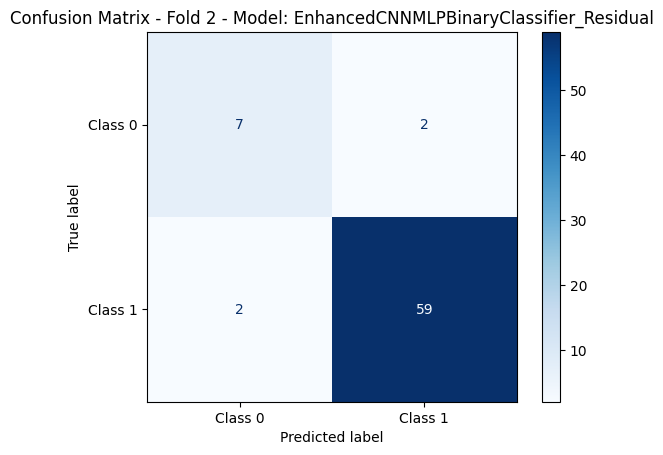


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6416, Val Loss: 0.5661, Train Acc: 0.6282, Val Acc: 0.8939
Fold 3 Epoch 1 Metrics - Precision: 0.9032, Recall: 0.9825, F1 Score: 0.9412, AUC-ROC: 0.6413
Initial best F1 score set to: 0.9412
Epoch [2/100], Train Loss: 0.4960, Val Loss: 0.4848, Train Acc: 0.7689, Val Acc: 0.8788
Fold 3 Epoch 2 Metrics - Precision: 0.8769, Recall: 1.0000, F1 Score: 0.9344, AUC-ROC: 0.5867
EarlyStopping counter: 1 out of 10
Epoch [3/100], Train Loss: 0.4521, Val Loss: 0.4842, Train Acc: 0.8025, Val Acc: 0.8333
Fold 3 Epoch 3 Metrics - Precision: 0.8710, Recall: 0.9474, F1 Score: 0.9076, AUC-ROC: 0.5497
EarlyStopping counter: 2 out of 10
Epoch [4/100], Train Loss: 0.4252, Val Loss: 0.5119, Train Acc: 0.8529, Val Acc: 0.7576
Fold 3 Epoch 4 Metrics - Precision: 0.8596, Recall: 0.8596, F1 Score: 0.8596, AUC-ROC: 0.5439
EarlyStopping counter: 3 out of 10
Epoch

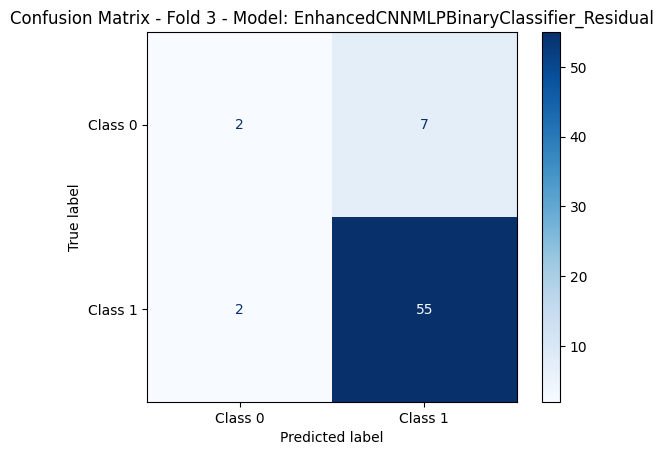


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6286, Val Loss: 0.5716, Train Acc: 0.6453, Val Acc: 0.8986
Fold 4 Epoch 1 Metrics - Precision: 0.9655, Recall: 0.9180, F1 Score: 0.9412, AUC-ROC: 0.8094
Initial best F1 score set to: 0.9412
Epoch [2/100], Train Loss: 0.5296, Val Loss: 0.4977, Train Acc: 0.7863, Val Acc: 0.9275
Fold 4 Epoch 2 Metrics - Precision: 0.9667, Recall: 0.9508, F1 Score: 0.9587, AUC-ROC: 0.8320
Validation F1 improved from 0.9412 to 0.9587. Resetting counter.
Epoch [3/100], Train Loss: 0.4794, Val Loss: 0.4925, Train Acc: 0.8504, Val Acc: 0.8406
Fold 4 Epoch 3 Metrics - Precision: 0.9630, Recall: 0.8525, F1 Score: 0.9043, AUC-ROC: 0.8607
EarlyStopping counter: 1 out of 10
Epoch [4/100], Train Loss: 0.4555, Val Loss: 0.5220, Train Acc: 0.8675, Val Acc: 0.8406
Fold 4 Epoch 4 Metrics - Precision: 0.9630, Recall: 0.8525, F1 Score: 0.9043, AUC-ROC: 0.8443
EarlyStopp

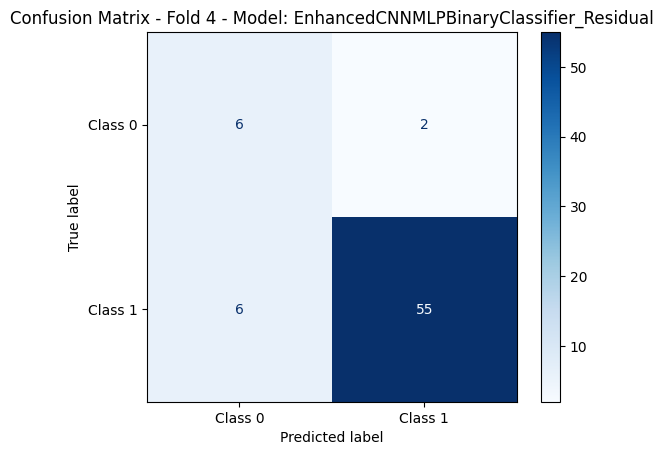


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6369, Val Loss: 0.7008, Train Acc: 0.6000, Val Acc: 0.6618
Fold 5 Epoch 1 Metrics - Precision: 0.9302, Recall: 0.6667, F1 Score: 0.7767, AUC-ROC: 0.7021
Initial best F1 score set to: 0.7767
Epoch [2/100], Train Loss: 0.5475, Val Loss: 0.6560, Train Acc: 0.7043, Val Acc: 0.7059
Fold 5 Epoch 2 Metrics - Precision: 0.9167, Recall: 0.7333, F1 Score: 0.8148, AUC-ROC: 0.7688
Validation F1 improved from 0.7767 to 0.8148. Resetting counter.
Epoch [3/100], Train Loss: 0.4786, Val Loss: 0.6175, Train Acc: 0.8234, Val Acc: 0.7059
Fold 5 Epoch 3 Metrics - Precision: 0.9348, Recall: 0.7167, F1 Score: 0.8113, AUC-ROC: 0.7812
EarlyStopping counter: 1 out of 10
Epoch [4/100], Train Loss: 0.4535, Val Loss: 0.5835, Train Acc: 0.8574, Val Acc: 0.6912
Fold 5 Epoch 4 Metrics - Precision: 0.9149, Recall: 0.7167, F1 Score: 0.8037, AUC-ROC: 0.7896
EarlyStopp

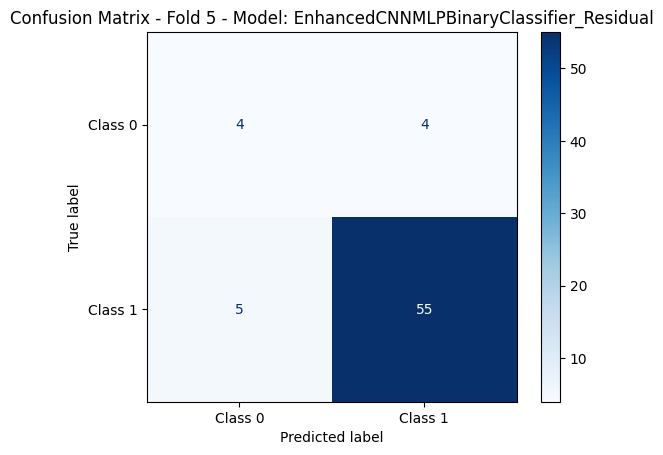


Model: EnhancedCNNMLPBinaryClassifier_Residual - Average Validation Accuracy: 0.8852
Average Precision: 0.9249
Average Recall: 0.9465
Average F1 Score: 0.9345
Average AUC-ROC: 0.8017

=== Benchmarking Model: MLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6590, Val Loss: 0.5288, Train Acc: 0.6151, Val Acc: 0.7941
Fold 1 Epoch 1 Metrics - Precision: 0.8750, Recall: 0.8750, F1 Score: 0.8750, AUC-ROC: 0.6414
Initial best F1 score set to: 0.8750
Epoch [2/100], Train Loss: 0.5701, Val Loss: 0.5319, Train Acc: 0.7406, Val Acc: 0.8088
Fold 1 Epoch 2 Metrics - Precision: 0.8909, Recall: 0.8750, F1 Score: 0.8829, AUC-ROC: 0.6101
Validation F1 improved from 0.8750 to 0.8829. Resetting counter.
Epoch [3/100], Train Loss: 0.5408, Val Loss: 0.5301, Train Acc: 0.7406, Val Acc: 0.8088
Fold 1 Epoch 3 Metrics - Precision: 0.8909, Recall: 0.8750, F1 Score: 0.8829, AUC-ROC: 

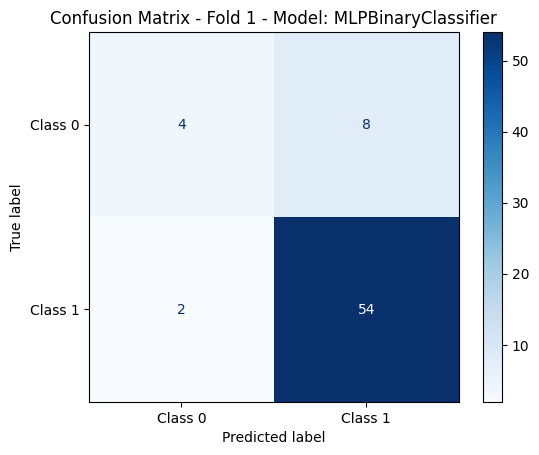


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6696, Val Loss: 0.6772, Train Acc: 0.5983, Val Acc: 0.5000
Fold 2 Epoch 1 Metrics - Precision: 0.9333, Recall: 0.4590, F1 Score: 0.6154, AUC-ROC: 0.8051
Initial best F1 score set to: 0.6154
Epoch [2/100], Train Loss: 0.6373, Val Loss: 0.6421, Train Acc: 0.6111, Val Acc: 0.7143
Fold 2 Epoch 2 Metrics - Precision: 0.9556, Recall: 0.7049, F1 Score: 0.8113, AUC-ROC: 0.8087
Validation F1 improved from 0.6154 to 0.8113. Resetting counter.
Epoch [3/100], Train Loss: 0.5899, Val Loss: 0.6085, Train Acc: 0.7094, Val Acc: 0.8286
Fold 2 Epoch 3 Metrics - Precision: 0.9623, Recall: 0.8361, F1 Score: 0.8947, AUC-ROC: 0.8197
Validation F1 improved from 0.8113 to 0.8947. Resetting counter.
Epoch [4/100], Train Loss: 0.5705, Val Loss: 0.5717, Train Acc: 0.7585, Val Acc: 0.8429
Fold 2 Epoch 4 Metrics - Precision: 0.9630, Recall: 0.8525, F1 Score: 0.90

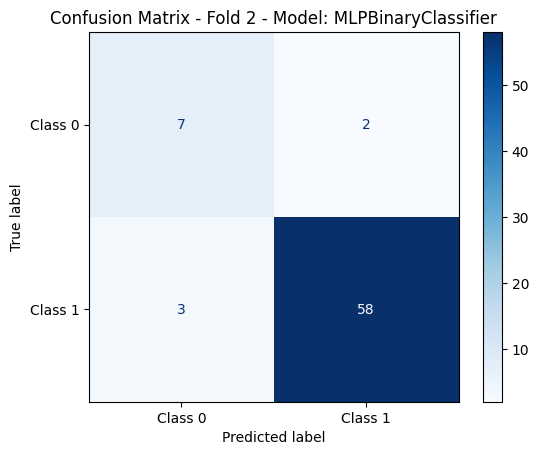


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6608, Val Loss: 0.6353, Train Acc: 0.5903, Val Acc: 0.5909
Fold 3 Epoch 1 Metrics - Precision: 0.8261, Recall: 0.6667, F1 Score: 0.7379, AUC-ROC: 0.4522
Initial best F1 score set to: 0.7379
Epoch [2/100], Train Loss: 0.5978, Val Loss: 0.5760, Train Acc: 0.7101, Val Acc: 0.7576
Fold 3 Epoch 2 Metrics - Precision: 0.8596, Recall: 0.8596, F1 Score: 0.8596, AUC-ROC: 0.5263
Validation F1 improved from 0.7379 to 0.8596. Resetting counter.
Epoch [3/100], Train Loss: 0.5903, Val Loss: 0.5385, Train Acc: 0.7416, Val Acc: 0.7576
Fold 3 Epoch 3 Metrics - Precision: 0.8596, Recall: 0.8596, F1 Score: 0.8596, AUC-ROC: 0.5906
Validation F1 improved from 0.8596 to 0.8596. Resetting counter.
Epoch [4/100], Train Loss: 0.5410, Val Loss: 0.5087, Train Acc: 0.8025, Val Acc: 0.7576
Fold 3 Epoch 4 Metrics - Precision: 0.8596, Recall: 0.8596, F1 Score: 0.85

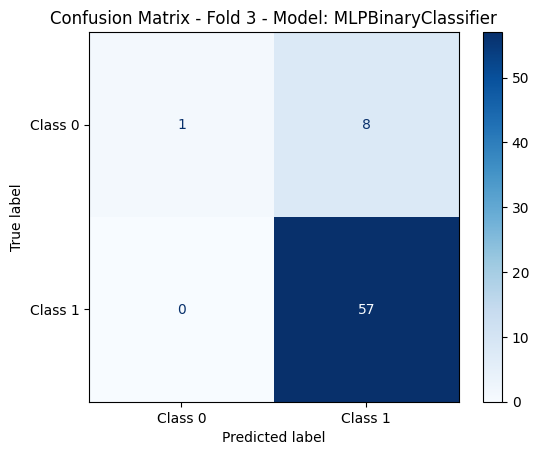


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6862, Val Loss: 0.5904, Train Acc: 0.5534, Val Acc: 0.8261
Fold 4 Epoch 1 Metrics - Precision: 0.9623, Recall: 0.8361, F1 Score: 0.8947, AUC-ROC: 0.7889
Initial best F1 score set to: 0.8947
Epoch [2/100], Train Loss: 0.6285, Val Loss: 0.5574, Train Acc: 0.6410, Val Acc: 0.8406
Fold 4 Epoch 2 Metrics - Precision: 0.9630, Recall: 0.8525, F1 Score: 0.9043, AUC-ROC: 0.7664
Validation F1 improved from 0.8947 to 0.9043. Resetting counter.
Epoch [3/100], Train Loss: 0.5859, Val Loss: 0.5274, Train Acc: 0.7329, Val Acc: 0.8551
Fold 4 Epoch 3 Metrics - Precision: 0.9636, Recall: 0.8689, F1 Score: 0.9138, AUC-ROC: 0.7848
Validation F1 improved from 0.9043 to 0.9138. Resetting counter.
Epoch [4/100], Train Loss: 0.5570, Val Loss: 0.4964, Train Acc: 0.7756, Val Acc: 0.8551
Fold 4 Epoch 4 Metrics - Precision: 0.9636, Recall: 0.8689, F1 Score: 0.91

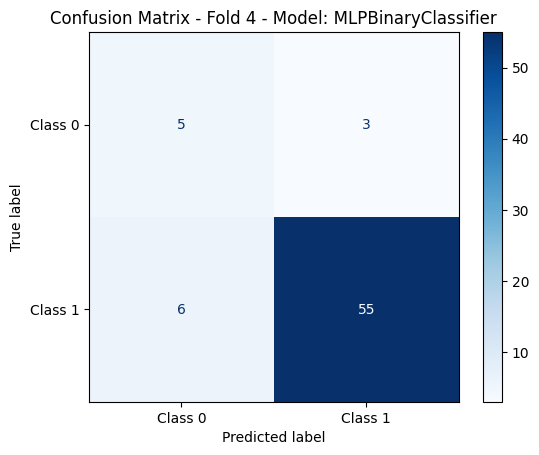


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6982, Val Loss: 0.6142, Train Acc: 0.5255, Val Acc: 0.7941
Fold 5 Epoch 1 Metrics - Precision: 0.9259, Recall: 0.8333, F1 Score: 0.8772, AUC-ROC: 0.7917
Initial best F1 score set to: 0.8772
Epoch [2/100], Train Loss: 0.6126, Val Loss: 0.5946, Train Acc: 0.6638, Val Acc: 0.8088
Fold 5 Epoch 2 Metrics - Precision: 0.9273, Recall: 0.8500, F1 Score: 0.8870, AUC-ROC: 0.7875
Validation F1 improved from 0.8772 to 0.8870. Resetting counter.
Epoch [3/100], Train Loss: 0.5477, Val Loss: 0.5707, Train Acc: 0.7681, Val Acc: 0.8088
Fold 5 Epoch 3 Metrics - Precision: 0.9273, Recall: 0.8500, F1 Score: 0.8870, AUC-ROC: 0.8042
Validation F1 improved from 0.8870 to 0.8870. Resetting counter.
Epoch [4/100], Train Loss: 0.5354, Val Loss: 0.5497, Train Acc: 0.8021, Val Acc: 0.8088
Fold 5 Epoch 4 Metrics - Precision: 0.9273, Recall: 0.8500, F1 Score: 0.88

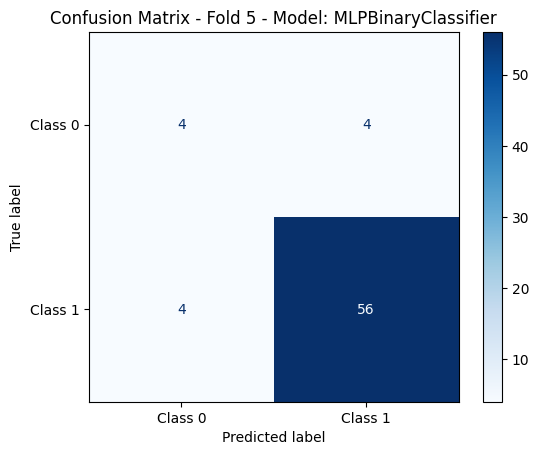


Model: MLPBinaryClassifier - Average Validation Accuracy: 0.8824
Average Precision: 0.9192
Average Recall: 0.9500
Average F1 Score: 0.9332
Average AUC-ROC: 0.7847

=== Benchmarking Model: ResidualMLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6581, Val Loss: 0.5085, Train Acc: 0.6527, Val Acc: 0.8088
Fold 1 Epoch 1 Metrics - Precision: 0.8644, Recall: 0.9107, F1 Score: 0.8870, AUC-ROC: 0.6637
Initial best F1 score set to: 0.8870
Epoch [2/100], Train Loss: 0.4118, Val Loss: 0.4927, Train Acc: 0.8243, Val Acc: 0.8088
Fold 1 Epoch 2 Metrics - Precision: 0.8644, Recall: 0.9107, F1 Score: 0.8870, AUC-ROC: 0.6562
Validation F1 improved from 0.8870 to 0.8870. Resetting counter.
Epoch [3/100], Train Loss: 0.3382, Val Loss: 0.4937, Train Acc: 0.8619, Val Acc: 0.8088
Fold 1 Epoch 3 Metrics - Precision: 0.8644, Recall: 0.9107, F1 Score: 0.8870, AUC-ROC: 0.6324
Valid

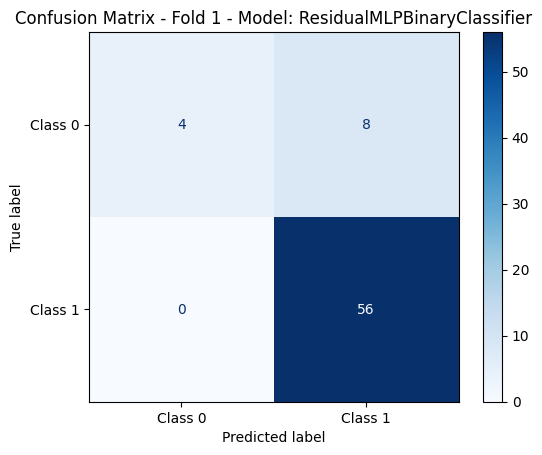


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6961, Val Loss: 0.5109, Train Acc: 0.6068, Val Acc: 0.8429
Fold 2 Epoch 1 Metrics - Precision: 0.9630, Recall: 0.8525, F1 Score: 0.9043, AUC-ROC: 0.7832
Initial best F1 score set to: 0.9043
Epoch [2/100], Train Loss: 0.4498, Val Loss: 0.3684, Train Acc: 0.7991, Val Acc: 0.8857
Fold 2 Epoch 2 Metrics - Precision: 0.9649, Recall: 0.9016, F1 Score: 0.9322, AUC-ROC: 0.7942
Validation F1 improved from 0.9043 to 0.9322. Resetting counter.
Epoch [3/100], Train Loss: 0.3347, Val Loss: 0.3428, Train Acc: 0.8825, Val Acc: 0.9286
Fold 2 Epoch 3 Metrics - Precision: 0.9667, Recall: 0.9508, F1 Score: 0.9587, AUC-ROC: 0.8197
Validation F1 improved from 0.9322 to 0.9587. Resetting counter.
Epoch [4/100], Train Loss: 0.2612, Val Loss: 0.2559, Train Acc: 0.9274, Val Acc: 0.9286
Fold 2 Epoch 4 Metrics - Precision: 0.9667, Recall: 0.9508, F1 Score: 0.95

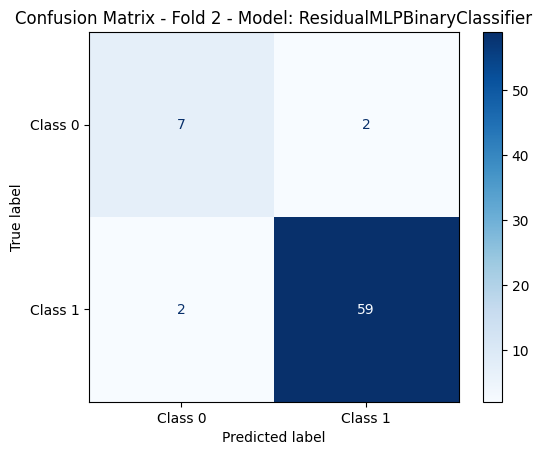


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6607, Val Loss: 0.4351, Train Acc: 0.6555, Val Acc: 0.8939
Fold 3 Epoch 1 Metrics - Precision: 0.9032, Recall: 0.9825, F1 Score: 0.9412, AUC-ROC: 0.6725
Initial best F1 score set to: 0.9412
Epoch [2/100], Train Loss: 0.4548, Val Loss: 0.3797, Train Acc: 0.8046, Val Acc: 0.9091
Fold 3 Epoch 2 Metrics - Precision: 0.9048, Recall: 1.0000, F1 Score: 0.9500, AUC-ROC: 0.6491
Validation F1 improved from 0.9412 to 0.9500. Resetting counter.
Epoch [3/100], Train Loss: 0.3234, Val Loss: 0.4204, Train Acc: 0.8592, Val Acc: 0.8333
Fold 3 Epoch 3 Metrics - Precision: 0.8966, Recall: 0.9123, F1 Score: 0.9043, AUC-ROC: 0.6472
EarlyStopping counter: 1 out of 10
Epoch [4/100], Train Loss: 0.2718, Val Loss: 0.3828, Train Acc: 0.9034, Val Acc: 0.8485
Fold 3 Epoch 4 Metrics - Precision: 0.8983, Recall: 0.9298, F1 Score: 0.9138, AUC-ROC: 0.6881
EarlyStopp

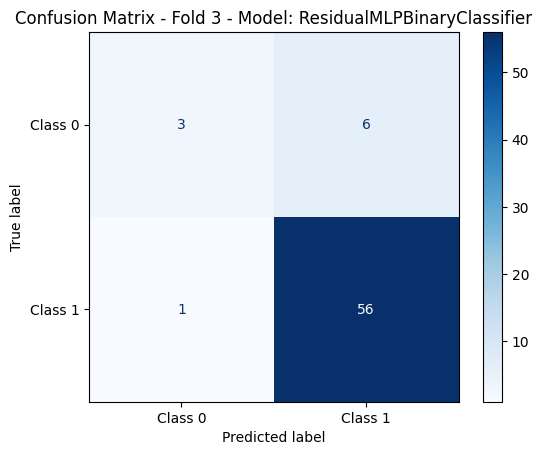


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6693, Val Loss: 0.4269, Train Acc: 0.6303, Val Acc: 0.8696
Fold 4 Epoch 1 Metrics - Precision: 0.9643, Recall: 0.8852, F1 Score: 0.9231, AUC-ROC: 0.8033
Initial best F1 score set to: 0.9231
Epoch [2/100], Train Loss: 0.4121, Val Loss: 0.3529, Train Acc: 0.8205, Val Acc: 0.8986
Fold 4 Epoch 2 Metrics - Precision: 0.9655, Recall: 0.9180, F1 Score: 0.9412, AUC-ROC: 0.8115
Validation F1 improved from 0.9231 to 0.9412. Resetting counter.
Epoch [3/100], Train Loss: 0.3212, Val Loss: 0.3212, Train Acc: 0.8932, Val Acc: 0.8986
Fold 4 Epoch 3 Metrics - Precision: 0.9655, Recall: 0.9180, F1 Score: 0.9412, AUC-ROC: 0.8156
Validation F1 improved from 0.9412 to 0.9412. Resetting counter.
Epoch [4/100], Train Loss: 0.2323, Val Loss: 0.2842, Train Acc: 0.9444, Val Acc: 0.8986
Fold 4 Epoch 4 Metrics - Precision: 0.9500, Recall: 0.9344, F1 Score: 0.94

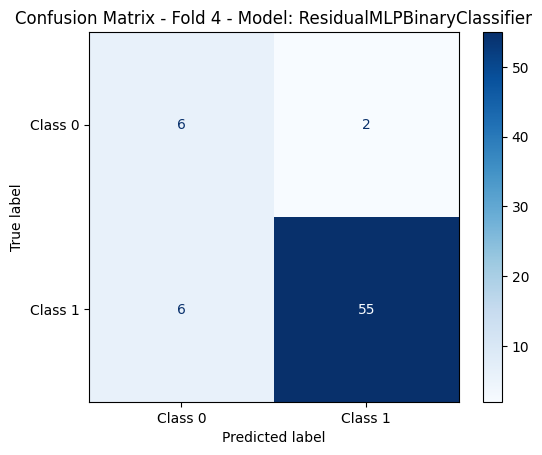


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6253, Val Loss: 0.5596, Train Acc: 0.6660, Val Acc: 0.7941
Fold 5 Epoch 1 Metrics - Precision: 0.9259, Recall: 0.8333, F1 Score: 0.8772, AUC-ROC: 0.6583
Initial best F1 score set to: 0.8772
Epoch [2/100], Train Loss: 0.4074, Val Loss: 0.4702, Train Acc: 0.8255, Val Acc: 0.8382
Fold 5 Epoch 2 Metrics - Precision: 0.9298, Recall: 0.8833, F1 Score: 0.9060, AUC-ROC: 0.7146
Validation F1 improved from 0.8772 to 0.9060. Resetting counter.
Epoch [3/100], Train Loss: 0.3053, Val Loss: 0.4416, Train Acc: 0.9000, Val Acc: 0.8382
Fold 5 Epoch 3 Metrics - Precision: 0.9298, Recall: 0.8833, F1 Score: 0.9060, AUC-ROC: 0.7583
Validation F1 improved from 0.9060 to 0.9060. Resetting counter.
Epoch [4/100], Train Loss: 0.2191, Val Loss: 0.3843, Train Acc: 0.9426, Val Acc: 0.8529
Fold 5 Epoch 4 Metrics - Precision: 0.9310, Recall: 0.9000, F1 Score: 0.91

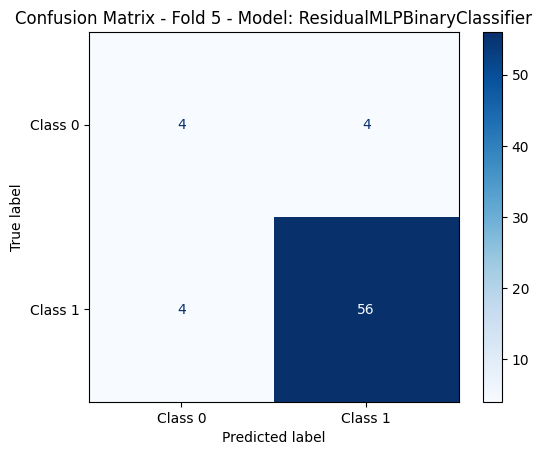


Model: ResidualMLPBinaryClassifier - Average Validation Accuracy: 0.8971
Average Precision: 0.9287
Average Recall: 0.9569
Average F1 Score: 0.9415
Average AUC-ROC: 0.7834

=== Benchmarking Model: EnhancedCNNMLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6494, Val Loss: 0.6594, Train Acc: 0.6046, Val Acc: 0.7206
Fold 1 Epoch 1 Metrics - Precision: 0.8776, Recall: 0.7679, F1 Score: 0.8190, AUC-ROC: 0.4911
Initial best F1 score set to: 0.8190
Epoch [2/100], Train Loss: 0.5601, Val Loss: 0.5779, Train Acc: 0.7113, Val Acc: 0.8382
Fold 1 Epoch 2 Metrics - Precision: 0.8814, Recall: 0.9286, F1 Score: 0.9043, AUC-ROC: 0.7798
Validation F1 improved from 0.8190 to 0.9043. Resetting counter.
Epoch [3/100], Train Loss: 0.5198, Val Loss: 0.5569, Train Acc: 0.7406, Val Acc: 0.8235
Fold 1 Epoch 3 Metrics - Precision: 0.8548, Recall: 0.9464, F1 Score: 0.8983, AUC-ROC: 0

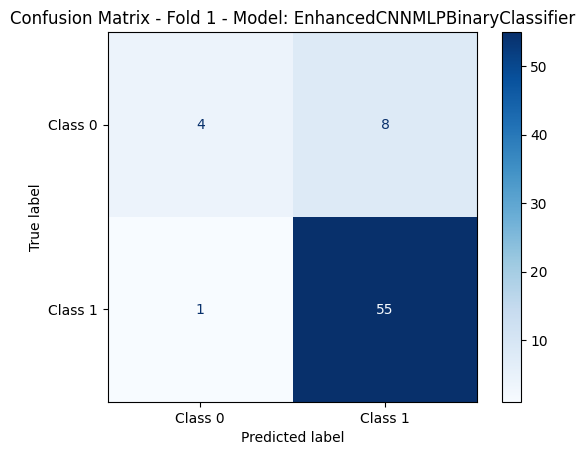


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6808, Val Loss: 0.7274, Train Acc: 0.5342, Val Acc: 0.2143
Fold 2 Epoch 1 Metrics - Precision: 1.0000, Recall: 0.0984, F1 Score: 0.1791, AUC-ROC: 0.8452
Initial best F1 score set to: 0.1791
Epoch [2/100], Train Loss: 0.5869, Val Loss: 0.6617, Train Acc: 0.6752, Val Acc: 0.5571
Fold 2 Epoch 2 Metrics - Precision: 0.9688, Recall: 0.5082, F1 Score: 0.6667, AUC-ROC: 0.9016
Validation F1 improved from 0.1791 to 0.6667. Resetting counter.
Epoch [3/100], Train Loss: 0.5535, Val Loss: 0.6452, Train Acc: 0.7158, Val Acc: 0.5857
Fold 2 Epoch 3 Metrics - Precision: 0.9706, Recall: 0.5410, F1 Score: 0.6947, AUC-ROC: 0.8980
Validation F1 improved from 0.6667 to 0.6947. Resetting counter.
Epoch [4/100], Train Loss: 0.5267, Val Loss: 0.6109, Train Acc: 0.7543, Val Acc: 0.7714
Fold 2 Epoch 4 Metrics - Precision: 0.9592, Recall: 0.7705, F1 Score: 0.85

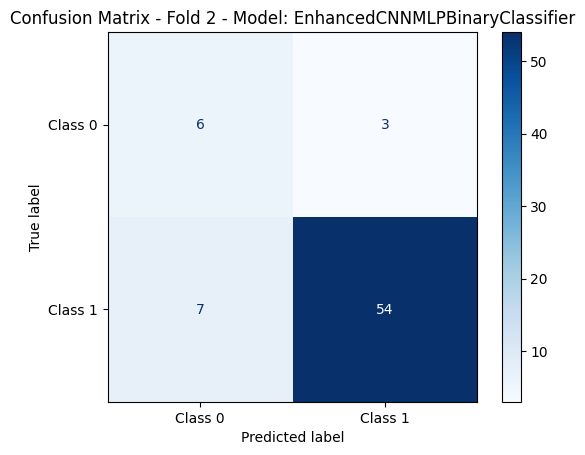


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6746, Val Loss: 0.6170, Train Acc: 0.6050, Val Acc: 0.8788
Fold 3 Epoch 1 Metrics - Precision: 0.8769, Recall: 1.0000, F1 Score: 0.9344, AUC-ROC: 0.5809
Initial best F1 score set to: 0.9344
Epoch [2/100], Train Loss: 0.5811, Val Loss: 0.5630, Train Acc: 0.7059, Val Acc: 0.8788
Fold 3 Epoch 2 Metrics - Precision: 0.8769, Recall: 1.0000, F1 Score: 0.9344, AUC-ROC: 0.3665
Validation F1 improved from 0.9344 to 0.9344. Resetting counter.
Epoch [3/100], Train Loss: 0.5279, Val Loss: 0.6425, Train Acc: 0.7458, Val Acc: 0.7576
Fold 3 Epoch 3 Metrics - Precision: 0.8596, Recall: 0.8596, F1 Score: 0.8596, AUC-ROC: 0.3645
EarlyStopping counter: 1 out of 10
Epoch [4/100], Train Loss: 0.5015, Val Loss: 0.6252, Train Acc: 0.7731, Val Acc: 0.7424
Fold 3 Epoch 4 Metrics - Precision: 0.8571, Recall: 0.8421, F1 Score: 0.8496, AUC-ROC: 0.4074
EarlyStopp

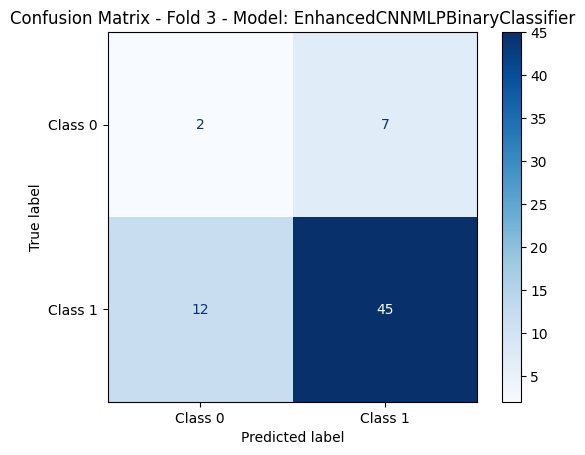


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6981, Val Loss: 0.6871, Train Acc: 0.5470, Val Acc: 0.5217
Fold 4 Epoch 1 Metrics - Precision: 0.9667, Recall: 0.4754, F1 Score: 0.6374, AUC-ROC: 0.8730
Initial best F1 score set to: 0.6374
Epoch [2/100], Train Loss: 0.5986, Val Loss: 0.6210, Train Acc: 0.6688, Val Acc: 0.8551
Fold 4 Epoch 2 Metrics - Precision: 0.9636, Recall: 0.8689, F1 Score: 0.9138, AUC-ROC: 0.8299
Validation F1 improved from 0.6374 to 0.9138. Resetting counter.
Epoch [3/100], Train Loss: 0.5572, Val Loss: 0.6327, Train Acc: 0.7158, Val Acc: 0.6957
Fold 4 Epoch 3 Metrics - Precision: 0.9545, Recall: 0.6885, F1 Score: 0.8000, AUC-ROC: 0.8504
EarlyStopping counter: 1 out of 10
Epoch [4/100], Train Loss: 0.5175, Val Loss: 0.6271, Train Acc: 0.7885, Val Acc: 0.6522
Fold 4 Epoch 4 Metrics - Precision: 0.9744, Recall: 0.6230, F1 Score: 0.7600, AUC-ROC: 0.8709
EarlyStopp

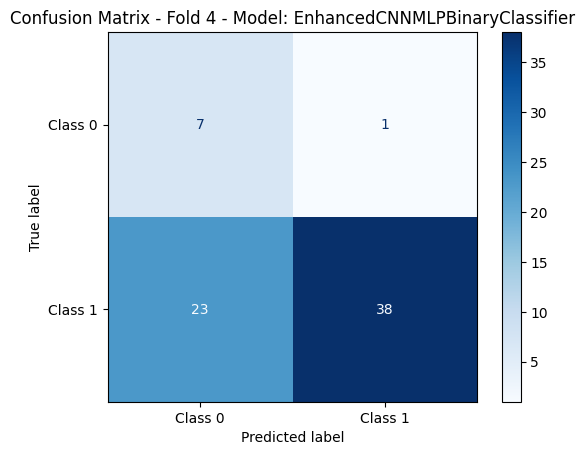


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6608, Val Loss: 0.6954, Train Acc: 0.6128, Val Acc: 0.6912
Fold 5 Epoch 1 Metrics - Precision: 0.9333, Recall: 0.7000, F1 Score: 0.8000, AUC-ROC: 0.7771
Initial best F1 score set to: 0.8000
Epoch [2/100], Train Loss: 0.5914, Val Loss: 0.6503, Train Acc: 0.6872, Val Acc: 0.7794
Fold 5 Epoch 2 Metrics - Precision: 0.9245, Recall: 0.8167, F1 Score: 0.8673, AUC-ROC: 0.8667
Validation F1 improved from 0.8000 to 0.8673. Resetting counter.
Epoch [3/100], Train Loss: 0.5586, Val Loss: 0.6262, Train Acc: 0.7426, Val Acc: 0.7941
Fold 5 Epoch 3 Metrics - Precision: 0.9259, Recall: 0.8333, F1 Score: 0.8772, AUC-ROC: 0.8000
Validation F1 improved from 0.8673 to 0.8772. Resetting counter.
Epoch [4/100], Train Loss: 0.5126, Val Loss: 0.6264, Train Acc: 0.7915, Val Acc: 0.7500
Fold 5 Epoch 4 Metrics - Precision: 0.9216, Recall: 0.7833, F1 Score: 0.84

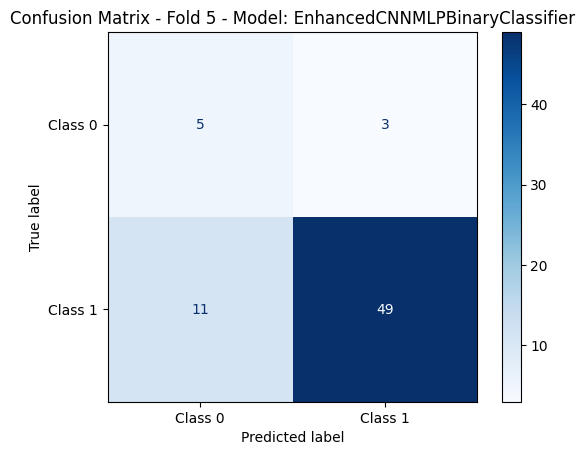


Model: EnhancedCNNMLPBinaryClassifier - Average Validation Accuracy: 0.7766
Average Precision: 0.9205
Average Recall: 0.8193
Average F1 Score: 0.8601
Average AUC-ROC: 0.7643

=== Benchmarking Model: TransformerBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6913, Val Loss: 0.7025, Train Acc: 0.5063, Val Acc: 0.4853
Fold 1 Epoch 1 Metrics - Precision: 0.8621, Recall: 0.4464, F1 Score: 0.5882, AUC-ROC: 0.6071
Initial best F1 score set to: 0.5882
Epoch [2/100], Train Loss: 0.6708, Val Loss: 0.6899, Train Acc: 0.5941, Val Acc: 0.6912
Fold 1 Epoch 2 Metrics - Precision: 0.8723, Recall: 0.7321, F1 Score: 0.7961, AUC-ROC: 0.6057
Validation F1 improved from 0.5882 to 0.7961. Resetting counter.
Epoch [3/100], Train Loss: 0.6416, Val Loss: 0.6730, Train Acc: 0.6674, Val Acc: 0.7353
Fold 1 Epoch 3 Metrics - Precision: 0.8800, Recall: 0.7857, F1 Score: 0.8302, AUC-ROC: 0

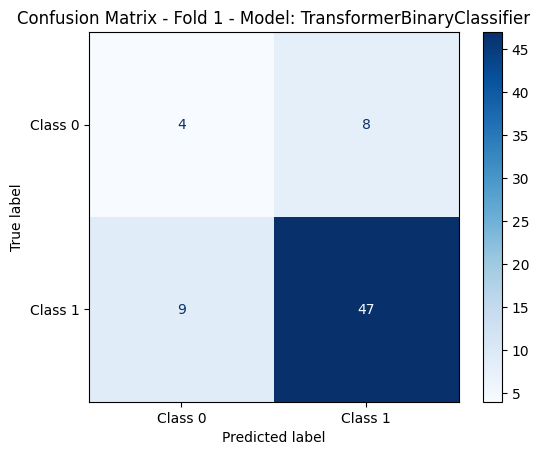


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6948, Val Loss: 0.6474, Train Acc: 0.5214, Val Acc: 0.8571
Fold 2 Epoch 1 Metrics - Precision: 0.9636, Recall: 0.8689, F1 Score: 0.9138, AUC-ROC: 0.8652
Initial best F1 score set to: 0.9138
Epoch [2/100], Train Loss: 0.6774, Val Loss: 0.6266, Train Acc: 0.5577, Val Acc: 0.8714
Fold 2 Epoch 2 Metrics - Precision: 0.9643, Recall: 0.8852, F1 Score: 0.9231, AUC-ROC: 0.8033
Validation F1 improved from 0.9138 to 0.9231. Resetting counter.
Epoch [3/100], Train Loss: 0.6637, Val Loss: 0.6103, Train Acc: 0.6432, Val Acc: 0.8429
Fold 2 Epoch 3 Metrics - Precision: 0.9630, Recall: 0.8525, F1 Score: 0.9043, AUC-ROC: 0.7832
EarlyStopping counter: 1 out of 10
Epoch [4/100], Train Loss: 0.6347, Val Loss: 0.5879, Train Acc: 0.6987, Val Acc: 0.8429
Fold 2 Epoch 4 Metrics - Precision: 0.9630, Recall: 0.8525, F1 Score: 0.9043, AUC-ROC: 0.7723
EarlyStopp

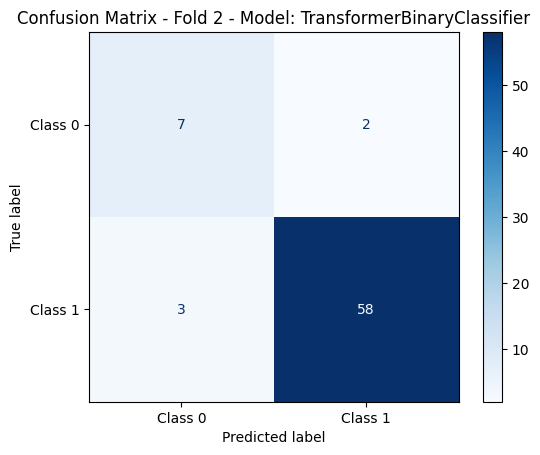


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6830, Val Loss: 0.6363, Train Acc: 0.5777, Val Acc: 0.8485
Fold 3 Epoch 1 Metrics - Precision: 0.8730, Recall: 0.9649, F1 Score: 0.9167, AUC-ROC: 0.6979
Initial best F1 score set to: 0.9167
Epoch [2/100], Train Loss: 0.6607, Val Loss: 0.5969, Train Acc: 0.6366, Val Acc: 0.8788
Fold 3 Epoch 2 Metrics - Precision: 0.8769, Recall: 1.0000, F1 Score: 0.9344, AUC-ROC: 0.7057
Validation F1 improved from 0.9167 to 0.9344. Resetting counter.
Epoch [3/100], Train Loss: 0.6442, Val Loss: 0.5553, Train Acc: 0.6765, Val Acc: 0.8788
Fold 3 Epoch 3 Metrics - Precision: 0.8769, Recall: 1.0000, F1 Score: 0.9344, AUC-ROC: 0.6764
Validation F1 improved from 0.9344 to 0.9344. Resetting counter.
Epoch [4/100], Train Loss: 0.6223, Val Loss: 0.5245, Train Acc: 0.6975, Val Acc: 0.8788
Fold 3 Epoch 4 Metrics - Precision: 0.8889, Recall: 0.9825, F1 Score: 0.93

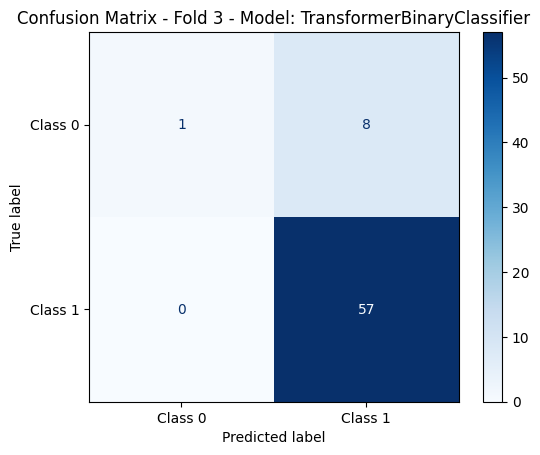


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.6984, Val Loss: 0.7349, Train Acc: 0.5021, Val Acc: 0.1159
Fold 4 Epoch 1 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.8299
Initial best F1 score set to: 0.0000
Epoch [2/100], Train Loss: 0.6898, Val Loss: 0.7004, Train Acc: 0.5150, Val Acc: 0.2609
Fold 4 Epoch 2 Metrics - Precision: 1.0000, Recall: 0.1639, F1 Score: 0.2817, AUC-ROC: 0.8525
Validation F1 improved from 0.0000 to 0.2817. Resetting counter.
Epoch [3/100], Train Loss: 0.6789, Val Loss: 0.6704, Train Acc: 0.5363, Val Acc: 0.8261
Fold 4 Epoch 3 Metrics - Precision: 0.9623, Recall: 0.8361, F1 Score: 0.8947, AUC-ROC: 0.8648
Validation F1 improved from 0.2817 to 0.8947. Resetting counter.
Epoch [4/100], Train Loss: 0.6591, Val Loss: 0.6398, Train Acc: 0.6132, Val Acc: 0.8841
Fold 4 Epoch 4 Metrics - Precision: 0.9649, Recall: 0.9016, F1 Score: 0.93

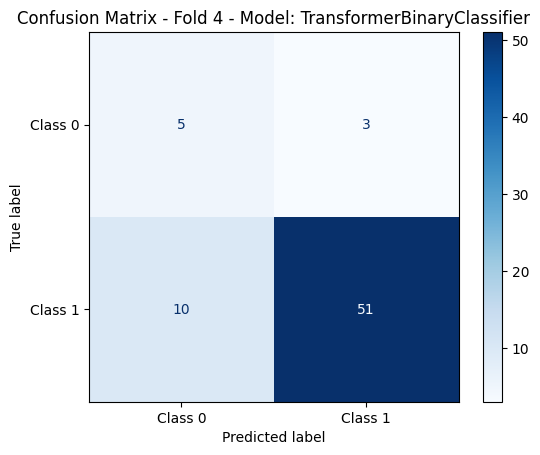


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Applying SMOTE oversampling to the training data.
Epoch [1/100], Train Loss: 0.7026, Val Loss: 0.7636, Train Acc: 0.5085, Val Acc: 0.1176
Fold 5 Epoch 1 Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.8667
Initial best F1 score set to: 0.0000
Epoch [2/100], Train Loss: 0.6860, Val Loss: 0.7402, Train Acc: 0.5106, Val Acc: 0.1618
Fold 5 Epoch 2 Metrics - Precision: 1.0000, Recall: 0.0500, F1 Score: 0.0952, AUC-ROC: 0.8646
Validation F1 improved from 0.0000 to 0.0952. Resetting counter.
Epoch [3/100], Train Loss: 0.6710, Val Loss: 0.6902, Train Acc: 0.5681, Val Acc: 0.7206
Fold 5 Epoch 3 Metrics - Precision: 0.9767, Recall: 0.7000, F1 Score: 0.8155, AUC-ROC: 0.8417
Validation F1 improved from 0.0952 to 0.8155. Resetting counter.
Epoch [4/100], Train Loss: 0.6424, Val Loss: 0.6393, Train Acc: 0.6362, Val Acc: 0.8235
Fold 5 Epoch 4 Metrics - Precision: 0.9286, Recall: 0.8667, F1 Score: 0.89

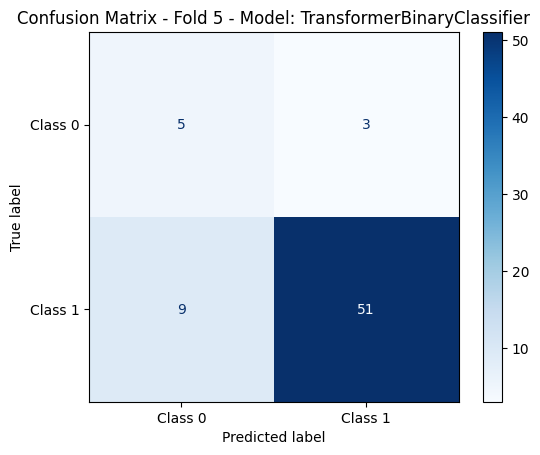


Model: TransformerBinaryClassifier - Average Validation Accuracy: 0.8385
Average Precision: 0.9174
Average Recall: 0.8952
Average F1 Score: 0.9043
Average AUC-ROC: 0.7591

=== Comparison of Benchmarking Results ===
No Resampling: {'EnhancedCNNMLPBinaryClassifier_Residual': {'Avg Validation Accuracy': 0.8825730450282879, 'Avg Precision': 0.927537035433112, 'Avg Recall': 0.940078269444102, 'Avg F1 Score': 0.9325411190117073, 'Avg AUC-ROC': 0.7998345248366818}, 'MLPBinaryClassifier': {'Avg Validation Accuracy': 0.9058503559526578, 'Avg Precision': 0.9232746174443689, 'Avg Recall': 0.9733764739718147, 'Avg F1 Score': 0.9470969164464105, 'Avg AUC-ROC': 0.7976092211402823}, 'ResidualMLPBinaryClassifier': {'Avg Validation Accuracy': 0.8942975609216018, 'Avg Precision': 0.922530407191962, 'Avg Recall': 0.9602617198734542, 'Avg F1 Score': 0.940191216982661, 'Avg AUC-ROC': 0.8360186212343246}, 'EnhancedCNNMLPBinaryClassifier': {'Avg Validation Accuracy': 0.891266040012843, 'Avg Precision': 0.92

In [91]:
# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the list of model classes to benchmark
model_classes = [
    EnhancedCNNMLPBinaryClassifier_Residual,
    MLPBinaryClassifier,
    ResidualMLPBinaryClassifier,
    EnhancedCNNMLPBinaryClassifier,
    TransformerBinaryClassifier
    # Add other model classes as needed
]

# # Benchmark with no resampling
print("=== Benchmarking with No Resampling ===")
results_no_resampling = benchmark_models(
    dataset=dataset,
    df=df_iso,
    device=device,
    model_classes=model_classes,
    num_epochs=100,
    batch_size=32,
    learning_rate=1e-4,
    hidden_dim=32,
    pos_weight=1.0,
    neg_weight=1.0,
    k_folds=5,
    sampling_method='none',  # Options: 'none', 'oversample', 'undersample'
    weight_decay=1e-5,
    patience=10,
    save_directory='saved_models/Isoforms/noresampling'
)

# Benchmark with SMOTE oversampling
print("\n=== Benchmarking with SMOTE Oversampling ===")
results_oversample = benchmark_models(
    dataset=dataset,
    df=df_iso,
    device=device,
    model_classes=model_classes,
    num_epochs=100,
    batch_size=32,
    learning_rate=1e-4,
    hidden_dim=64,
    pos_weight=1.0,
    neg_weight=1.0,
    k_folds=5,
    sampling_method='oversample',  # Options: 'none', 'oversample', 'undersample'
    weight_decay=1e-5,
    patience=10,
    save_directory='saved_models/Isoforms/oversampling'
)

# # # Benchmark with Random Undersampling
# print("\n=== Benchmarking with Random Undersampling ===")
# results_undersample = benchmark_models(
#     dataset=dataset,
#     df=df_iso,
#     device=device,
#     model_classes=model_classes,
#     num_epochs=100,
#     batch_size=32,
#     learning_rate=1e-4,
#     hidden_dim=64,
#     pos_weight=1.0,
#     neg_weight=1.0,
#     k_folds=5,
#     sampling_method='undersample',  # Options: 'none', 'oversample', 'undersample'
#     weight_decay=1e-5,
#     patience=10,
#     save_directory='saved_models/Isoforms/undersampling'
# )

# Optionally, compare results
print("\n=== Comparison of Benchmarking Results ===")
print("No Resampling:", results_no_resampling)
# print("Oversampling:", results_oversample)
# print("Undersampling:", results_undersample)
